In [2]:
import sys
import glob
import pickle
import os
import random
from enum import Enum

import cv2 as cv
import scipy.io as sio
import pickle
import pdb
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import metrics
from PIL import Image

import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import requests

from object_detection_utils import (
    COLORS,
    preprocess,
    box_cxcywh_to_xyxy,
    rescale_bboxes,
    batch_detect,
    detect,
    plot_results,
    plot_batch_detections,
    plot_batch_detections,
    # plot_results_avenue,
    load_images_from_folder,
    list_files,
    list_image_files,
    save_cropped_images,
    imshow,
    plot_images_vs_reconstructed_images,
    load_artefact,
    get_directory_names,
)

In [3]:
import sys

sys.path.append("./ml-fastvit")

import timm
import torch
import torch.optim as optim
import torchvision.utils as vutils
import torchvision.transforms as T
import torch.nn as nn
import models
import math
import matplotlib.pyplot as plt
import numpy as np
import gc

from torch import Tensor
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timm.models import create_model
from models.modules.mobileone import reparameterize_model
from PIL import Image
from urllib.request import urlopen

from UpsampleTransformerDecoder import UpsampleTransformerDecoder
from Autoencoder import AvenueAutoencoder, CNNAutoencoder

# Before starting the training, make sure to clear any residual memory
gc.collect()
torch.cuda.empty_cache()

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

If for semantic segmentation, please install mmsegmentation first
If for detection, please install mmdetection first
cuda


In [4]:
from anomaly_detection_utils import (
    compute_fpr_rbdr,
    AnomalyDetection,
    process_current_vid_preds,
    read_txt_to_numpy_array,
    compute_macro_auc,
    compute_micro_auc,
    compute_anomaly_reconstruction_scores,
)

## Initialize Test Data and Ground truths

### Avenue

In [14]:
test_dir = "./datasets/Avenue Dataset/test__/"
test_video_dirs = [
    "01",
    "02",
    "03",
    "04",
    "05",
    "06",
    "07",
    "08",
    "09",
    "10",
    "11",
    "12",
    "13",
    "14",
    "15",
    "16",
    "17",
    "18",
    "19",
    "20",
    "21",
]
test_video_paths = []
total_frames = 0
for dir in test_video_dirs:
    cur_dir = os.path.join(test_dir, dir)
    test_video_paths.append(cur_dir)
    jpg_files = [f for f in os.listdir(cur_dir) if f.endswith(".jpg")]
    total_frames += len(jpg_files)
    # print(cur_dir, len(jpg_files))
# print(f"Total Frames: {total_frames}")
num_frames = total_frames

image_names = [img.split("/")[-1] for img in list_image_files(test_video_paths[-1])]
video_names = [video.split("/")[-1] for video in test_video_paths]

path = "./tracks/tracks_avenue/"
video_names = [
    file.split("/")[-1].split(".")[0] for file in list_files(path) if "cont" not in file
]
pkl_files = [file for file in list_files(path) if "cont" not in file]

In [15]:
labels_path = "./datasets/Avenue Dataset/gt/"
labels_dict = {}

for vid_name in video_names:
    labels_dict[vid_name] = read_txt_to_numpy_array(
        os.path.join(labels_path, f"{vid_name}.txt")
    )
print(np.array(labels_dict["01"]))

[0. 0. 0. ... 0. 0. 0.]


### Shanghaitech

In [ ]:
test_dir = "./datasets/shanghaitech/testing/frames/"

# Example usage
test_video_dirs = get_directory_names(test_dir)
print(test_video_dirs[:5])

test_video_paths = []
total_frames = 0
for dir in test_video_dirs:
    cur_dir = os.path.join(test_dir, dir)
    test_video_paths.append(cur_dir)
    jpg_files = [f for f in os.listdir(cur_dir) if f.endswith(".jpg")]
    total_frames += len(jpg_files)
    # print(cur_dir, len(jpg_files))
# print(f"Total Frames: {total_frames}") # 40791
num_frames = total_frames

In [18]:
image_names = [img.split("/")[-1] for img in list_image_files(test_video_paths[-1])]
print(image_names[:5])

['000.jpg', '001.jpg', '002.jpg', '003.jpg', '004.jpg']


In [19]:
print(test_video_dirs[:5])

['01_0014', '01_0015', '01_0016', '01_0025', '01_0026']


In [20]:
path = "./tracks/tracks_shanghai/"
video_names = [
    file.split("/")[-1].split(".")[0] for file in list_files(path) if "cont" not in file
]
pkl_files = [file for file in list_files(path) if "cont" not in file]
print(video_names[:3])
print(pkl_files[:3])

['01_0014', '01_0015', '01_0016']
['./tracks/tracks_shanghai/01_0014.pkl', './tracks/tracks_shanghai/01_0015.pkl', './tracks/tracks_shanghai/01_0016.pkl']


### UBNormal

In [ ]:
test_dir = "./datasets/UBNormal/test/"
normal_test_dir = os.path.join(test_dir, "test_normal_frames/")
abnormal_test_dir = os.path.join(test_dir, "test_abnormal_frames/")

test_video_dirs = get_directory_names(normal_test_dir)
ab_test_dirs = get_directory_names(abnormal_test_dir)

# test_video_paths = []
# total_frames = 0
# for dir in test_video_dirs:
#     cur_dir = os.path.join(test_dir, dir)
#     test_video_paths.append(cur_dir)
#     jpg_files = [f for f in os.listdir(cur_dir) if f.endswith('.jpg')]
#     total_frames += len(jpg_files)
#     print(cur_dir, len(jpg_files))

test_video_paths = []
total_frames = 0
for dir in test_video_dirs:
    cur_dir = os.path.join(normal_test_dir, dir)
    test_video_paths.append(cur_dir)
    jpg_files = [f for f in os.listdir(cur_dir) if f.endswith(".jpg")]
    total_frames += len(jpg_files)
    print(cur_dir, len(jpg_files))

for dir in ab_test_dirs:
    cur_dir = os.path.join(abnormal_test_dir, dir)
    test_video_paths.append(cur_dir)
    jpg_files = [f for f in os.listdir(cur_dir) if f.endswith(".jpg")]
    total_frames += len(jpg_files)
    print(cur_dir, len(jpg_files))

print(len(test_video_paths))  # 53
print(f"Total Frames: {total_frames}")  # 23593
num_frames = total_frames

In [8]:
image_names = [img.split("/")[-1] for img in list_image_files(test_video_paths[-1])]
print(image_names[:5])

['abnormal_scene_9_scenario_8_0000.jpg', 'abnormal_scene_9_scenario_8_0001.jpg', 'abnormal_scene_9_scenario_8_0002.jpg', 'abnormal_scene_9_scenario_8_0003.jpg', 'abnormal_scene_9_scenario_8_0004.jpg']


In [9]:
print(test_video_dirs[:5])

['normal_scene_10_scenario_2', 'normal_scene_10_scenario_3', 'normal_scene_10_scenario_8', 'normal_scene_10_scenario_9', 'normal_scene_11_scenario_2_fog']


In [10]:
video_names = [vid.split("/")[-1] for vid in test_video_paths]
# print(video_names)

## Example Anomaly Detection objects

### Avenue & Shanghaitech

In [16]:
# Get GT for RBDC and TBDC
all_gt_tracks = []
num_tracks = 0

for vn, pkl_file in zip(video_names, pkl_files):
    tracks = pickle.load(open(os.path.join(pkl_file), "rb"))
    all_gt_tracks += tracks

num_tracks = len(all_gt_tracks)
print("All GT Tracks: ", num_tracks, all_gt_tracks[:2])

gt_anomalies = []
for track_id, track in enumerate(all_gt_tracks):
    for frame_idx, bbox in track.bboxes.items():
        gt_anomalies.append(
            AnomalyDetection(frame_idx, bbox, 1, track.video_name, track_id=track_id)
        )

print("GT Anomalies: ", len(gt_anomalies), gt_anomalies[:2])

All GT Tracks:  121 [<evaluation.track.Track object at 0x7ff1ac2bdae0>, <evaluation.track.Track object at 0x7ff0b43725c0>]
GT Anomalies:  3914 [<anomaly_detection_utils.AnomalyDetection object at 0x7ff0b4513c70>, <anomaly_detection_utils.AnomalyDetection object at 0x7ff0b4513cd0>]


### UBNormal

In [84]:
# Import pickle file
import pickle

with open("ubnormal_all_test_gt_tracks", "rb") as file:
    all_gt_tracks = pickle.load(file)

num_tracks = len(all_gt_tracks)
print("All GT Tracks: ", num_tracks, all_gt_tracks[:2])

gt_anomalies = []
for track_id, track in enumerate(all_gt_tracks):
    for frame_idx, bbox in track.bboxes.items():
        gt_anomalies.append(
            AnomalyDetection(frame_idx, bbox, 1, track.video_name, track_id=track_id)
        )

print("GT Anomalies: ", len(gt_anomalies), gt_anomalies[:2])

All GT Tracks:  158 [<__main__.Track object at 0x7fc3a8864790>, <__main__.Track object at 0x7fc37e783a60>]
GT Anomalies:  34616 [<__main__.AnomalyDetection object at 0x7fc2e58fc100>, <__main__.AnomalyDetection object at 0x7fc2e58fc160>]


- Fiecare video are propriul track -> deci All GT Tracks are aceeasi lungime ca numarul de video-uri
- In fiecare track, ai {frame_idx: [bounding box], ....}

### Checks

In [17]:
print(all_gt_tracks[0].video_name)
print(all_gt_tracks[0].mask)
print(all_gt_tracks[0].bboxes)

print(gt_anomalies[0].frame_idx, gt_anomalies[0].video_name, gt_anomalies[0].bbox)
print(gt_anomalies[1].frame_idx, gt_anomalies[1].video_name, gt_anomalies[1].bbox)
print(gt_anomalies[2].frame_idx, gt_anomalies[2].video_name, gt_anomalies[2].bbox)
print(gt_anomalies[3].frame_idx, gt_anomalies[3].video_name, gt_anomalies[3].bbox)

compute_fpr_rbdr(
    gt_anomalies, gt_anomalies, all_gt_tracks, num_frames=1000, num_tracks=num_tracks
)

01
0
{77: [9, 114, 69, 220], 78: [10, 112, 82, 220], 79: [25, 116, 88, 220], 80: [40, 117, 96, 221], 81: [55, 116, 98, 223], 82: [71, 116, 102, 224]}
77 01 [9, 114, 69, 220]
78 01 [10, 112, 82, 220]
79 01 [25, 116, 88, 220]
80 01 [40, 117, 96, 221]
fpr does not reach 1
tbdc = 1.0
rbdc = 1.0


(1.0, 1.0)

## Import AutoEncoder which will be used to compute Anomaly Score

### Avenue Autoencoder

In [8]:
autoencoder_path = "autoencoder_t12_decoder_yolov8_2_adamw_numheads_8_ffdim_1024_numblocks_2_epoch_17_mseloss_0.0025767571664901574.pth"
# autoencoder_path = 'autoencoder_avenue_ubnormal_adversarial_random_teacher_t12_decoder_yolov8_adamw_epoch_28_loss_0.004644697113970326_abloss_0.010860763371389344.pth'
autoencoder = AvenueAutoencoder(autoencoder_path).to(device)

# Freeze encoder weights
for param in autoencoder.parameters():
    param.requires_grad = False

In [70]:
# Function to normalize and visualize an image
def visualize_image(image_tensor):
    img = image_tensor.cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
    plt.imshow(img)
    plt.axis("off")
    plt.show()


def visualize_batch(image_batch):
    # Determine the number of images in the batch and arrange the grid accordingly
    batch_size = len(image_batch)
    num_cols = int(np.sqrt(batch_size))
    num_rows = batch_size // num_cols + (batch_size % num_cols > 0)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
    if (
        num_rows == 1 or num_cols == 1
    ):  # If there's only one row or column, axes is a 1D array
        axes = np.array([axes]).flatten()  # Ensure axes is always a 2D array

    for i, img_tensor in enumerate(image_batch):
        img = img_tensor.cpu().numpy()
        img = np.transpose(img, (1, 2, 0))  # Adjust dimensions for plotting
        img = (img - img.min()) / (img.max() - img.min())  # Normalize the image

        # Plot the image
        ax = axes.flatten()[i]
        ax.imshow(img)
        ax.axis("off")

    # Hide any empty subplots
    for j in range(i + 1, len(axes.flatten())):
        axes.flatten()[j].axis("off")

    plt.show()

In [72]:
# # Initialize Autoencoder
# autoencoder_path = 'autoencoder_t12_decoder_yolov8_2_adamw_numheads_8_ffdim_1024_numblocks_2_epoch_17_mseloss_0.0025767571664901574.pth'
# encoder.load_state_dict(torch.load(autoencoder_path)['encoder_state_dict'])
# decoder.load_state_dict(torch.load(autoencoder_path)['decoder_state_dict'])

# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         self.encoder = encoder
#         self.decoder = decoder

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x[-1])
#         return x

# autoencoder = Autoencoder()
# autoencoder = autoencoder.to(device)

# # Create Clusters
# num_clusters = 500
# clusters_name = "avenue_cluster_centers_num_500_2048.pkl"
# with open(clusters_name, 'rb') as file:
#     cluster_centers = pickle.load(file)
# cluster_centers_tensor = torch.Tensor(cluster_centers).float().to(device)
# print(cluster_centers_tensor.shape)
# reshaped_clusters = cluster_centers_tensor.view(500, 512, 2, 2)

# # Define batch size
# batch_size = 64

# # Iterate through reshaped clusters in batches
# for i in range(0, len(reshaped_clusters), batch_size):
#     batch = reshaped_clusters[i:i + batch_size]

#     # Pass the batch through the decoder
#     with torch.no_grad():
#         reconstructed_clusters = autoencoder.decoder(batch)

#         # Visualize each reconstructed cluster separately
#         # for img in reconstructed_clusters:
#         #     visualize_image(img)
#         visualize_batch(reconstructed_clusters)

torch.Size([500, 2048])


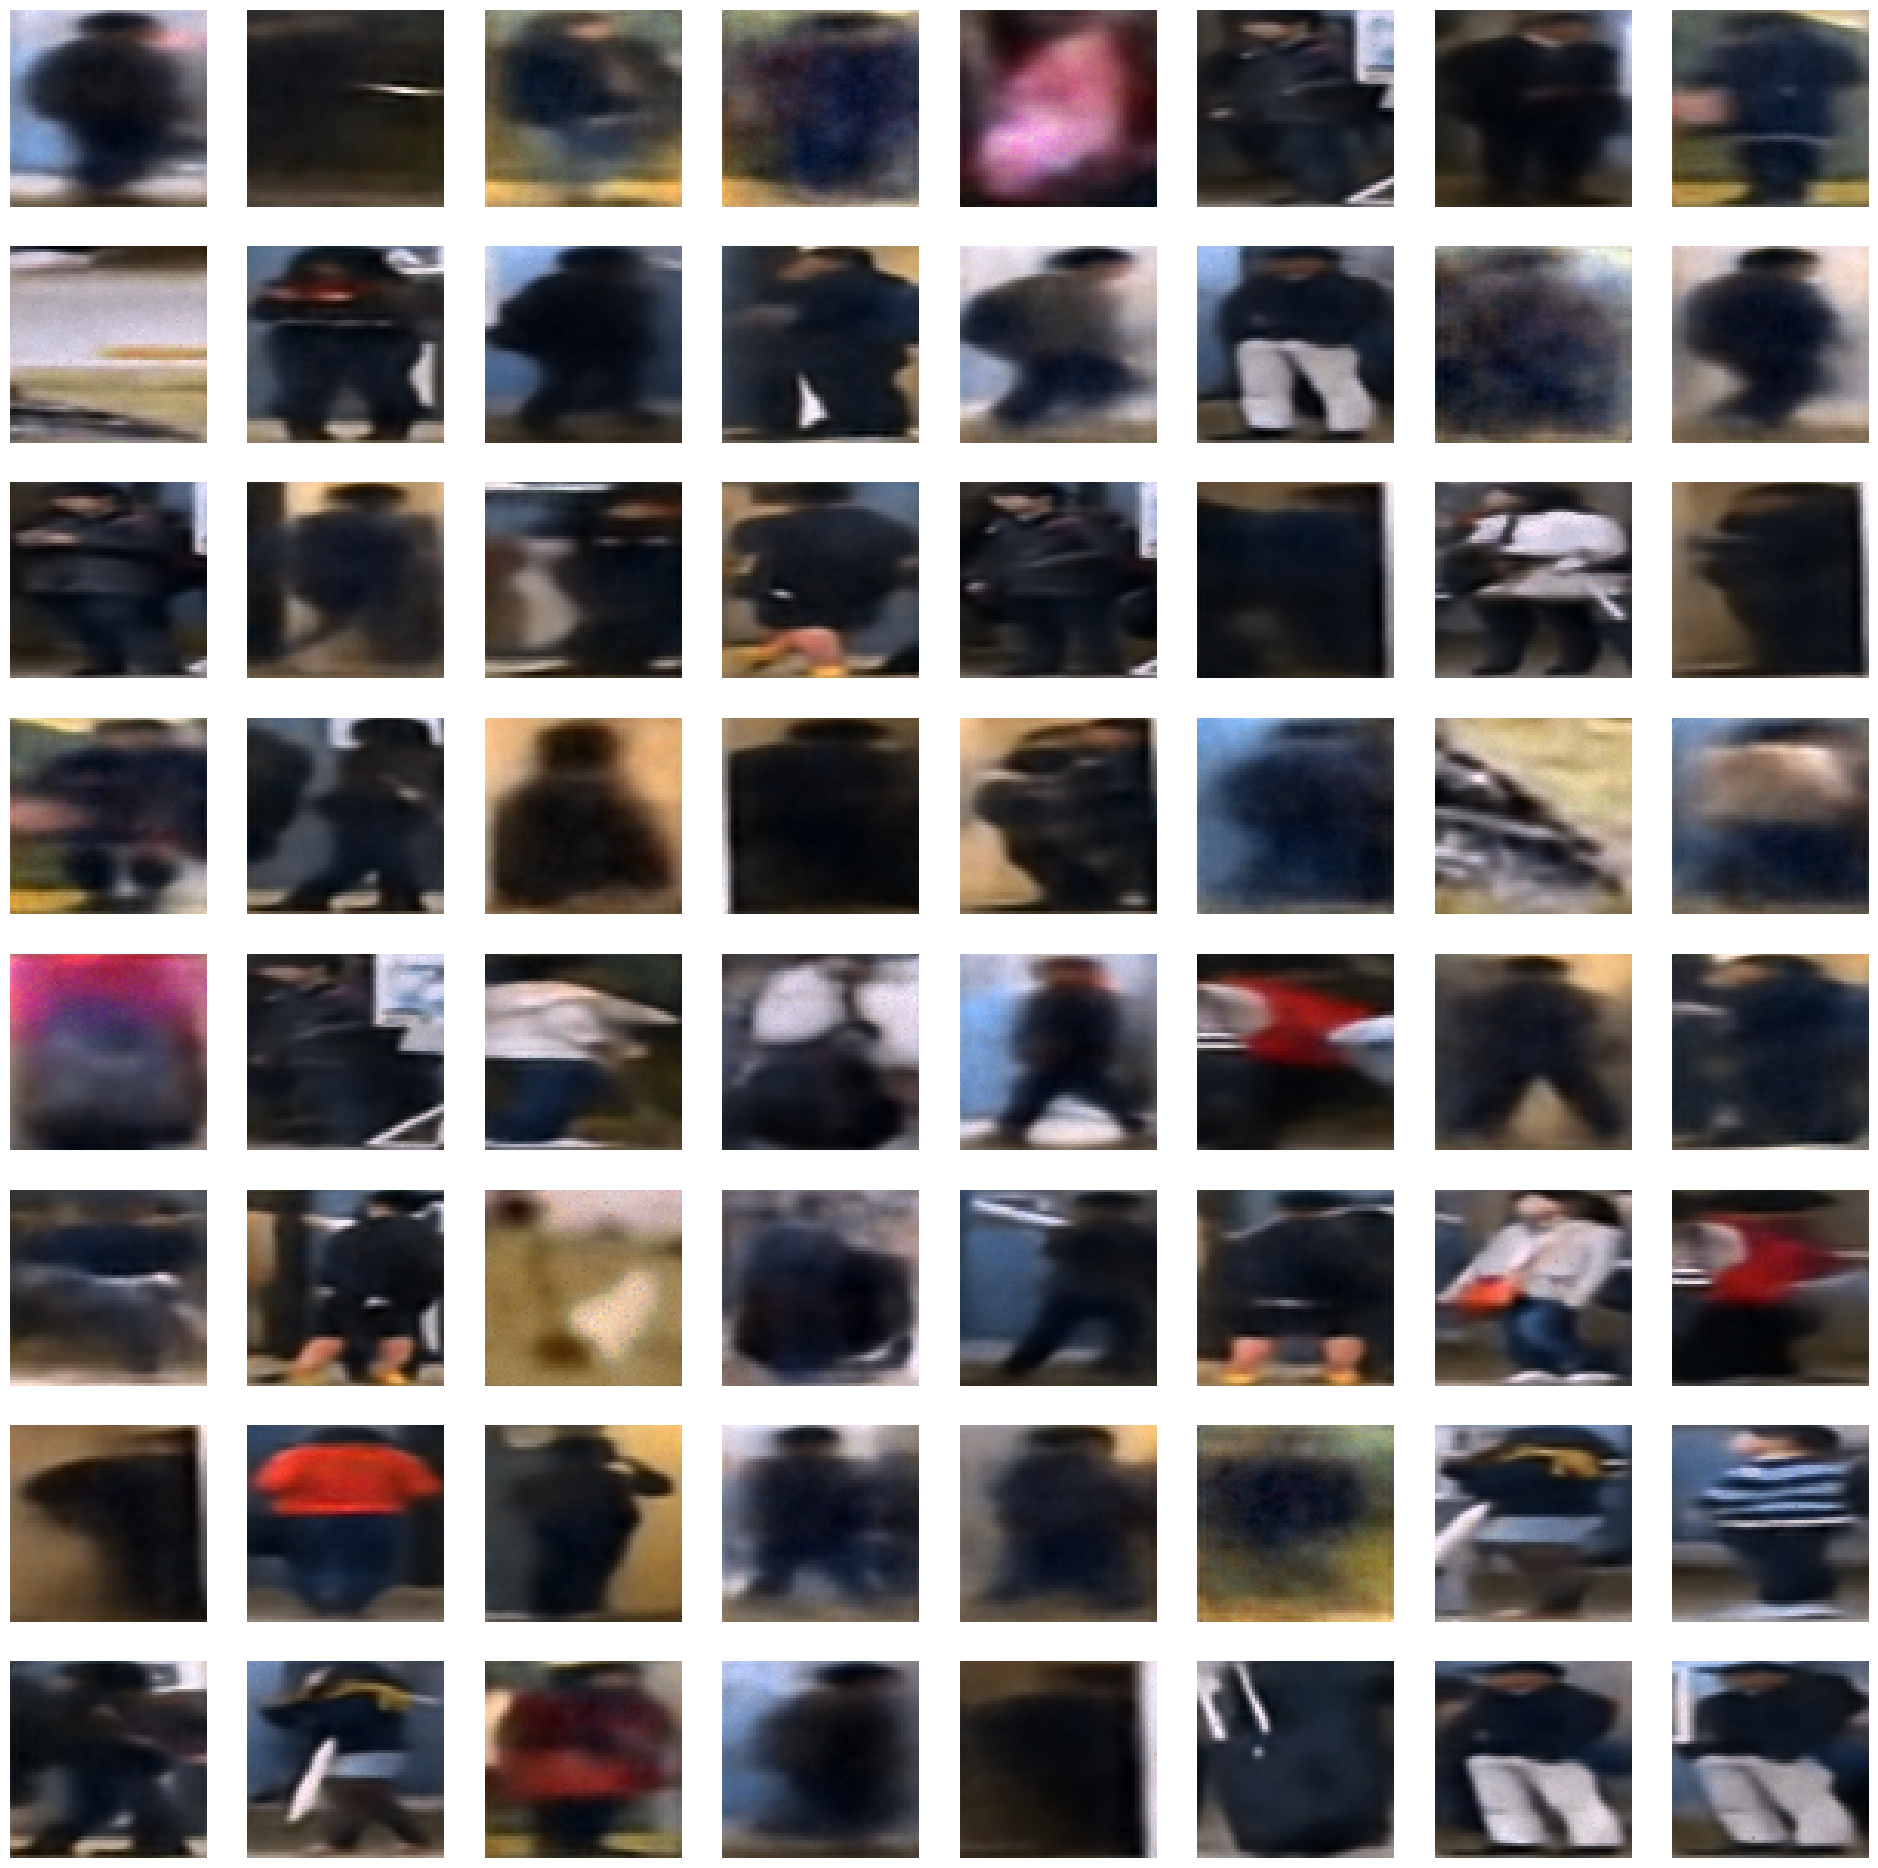

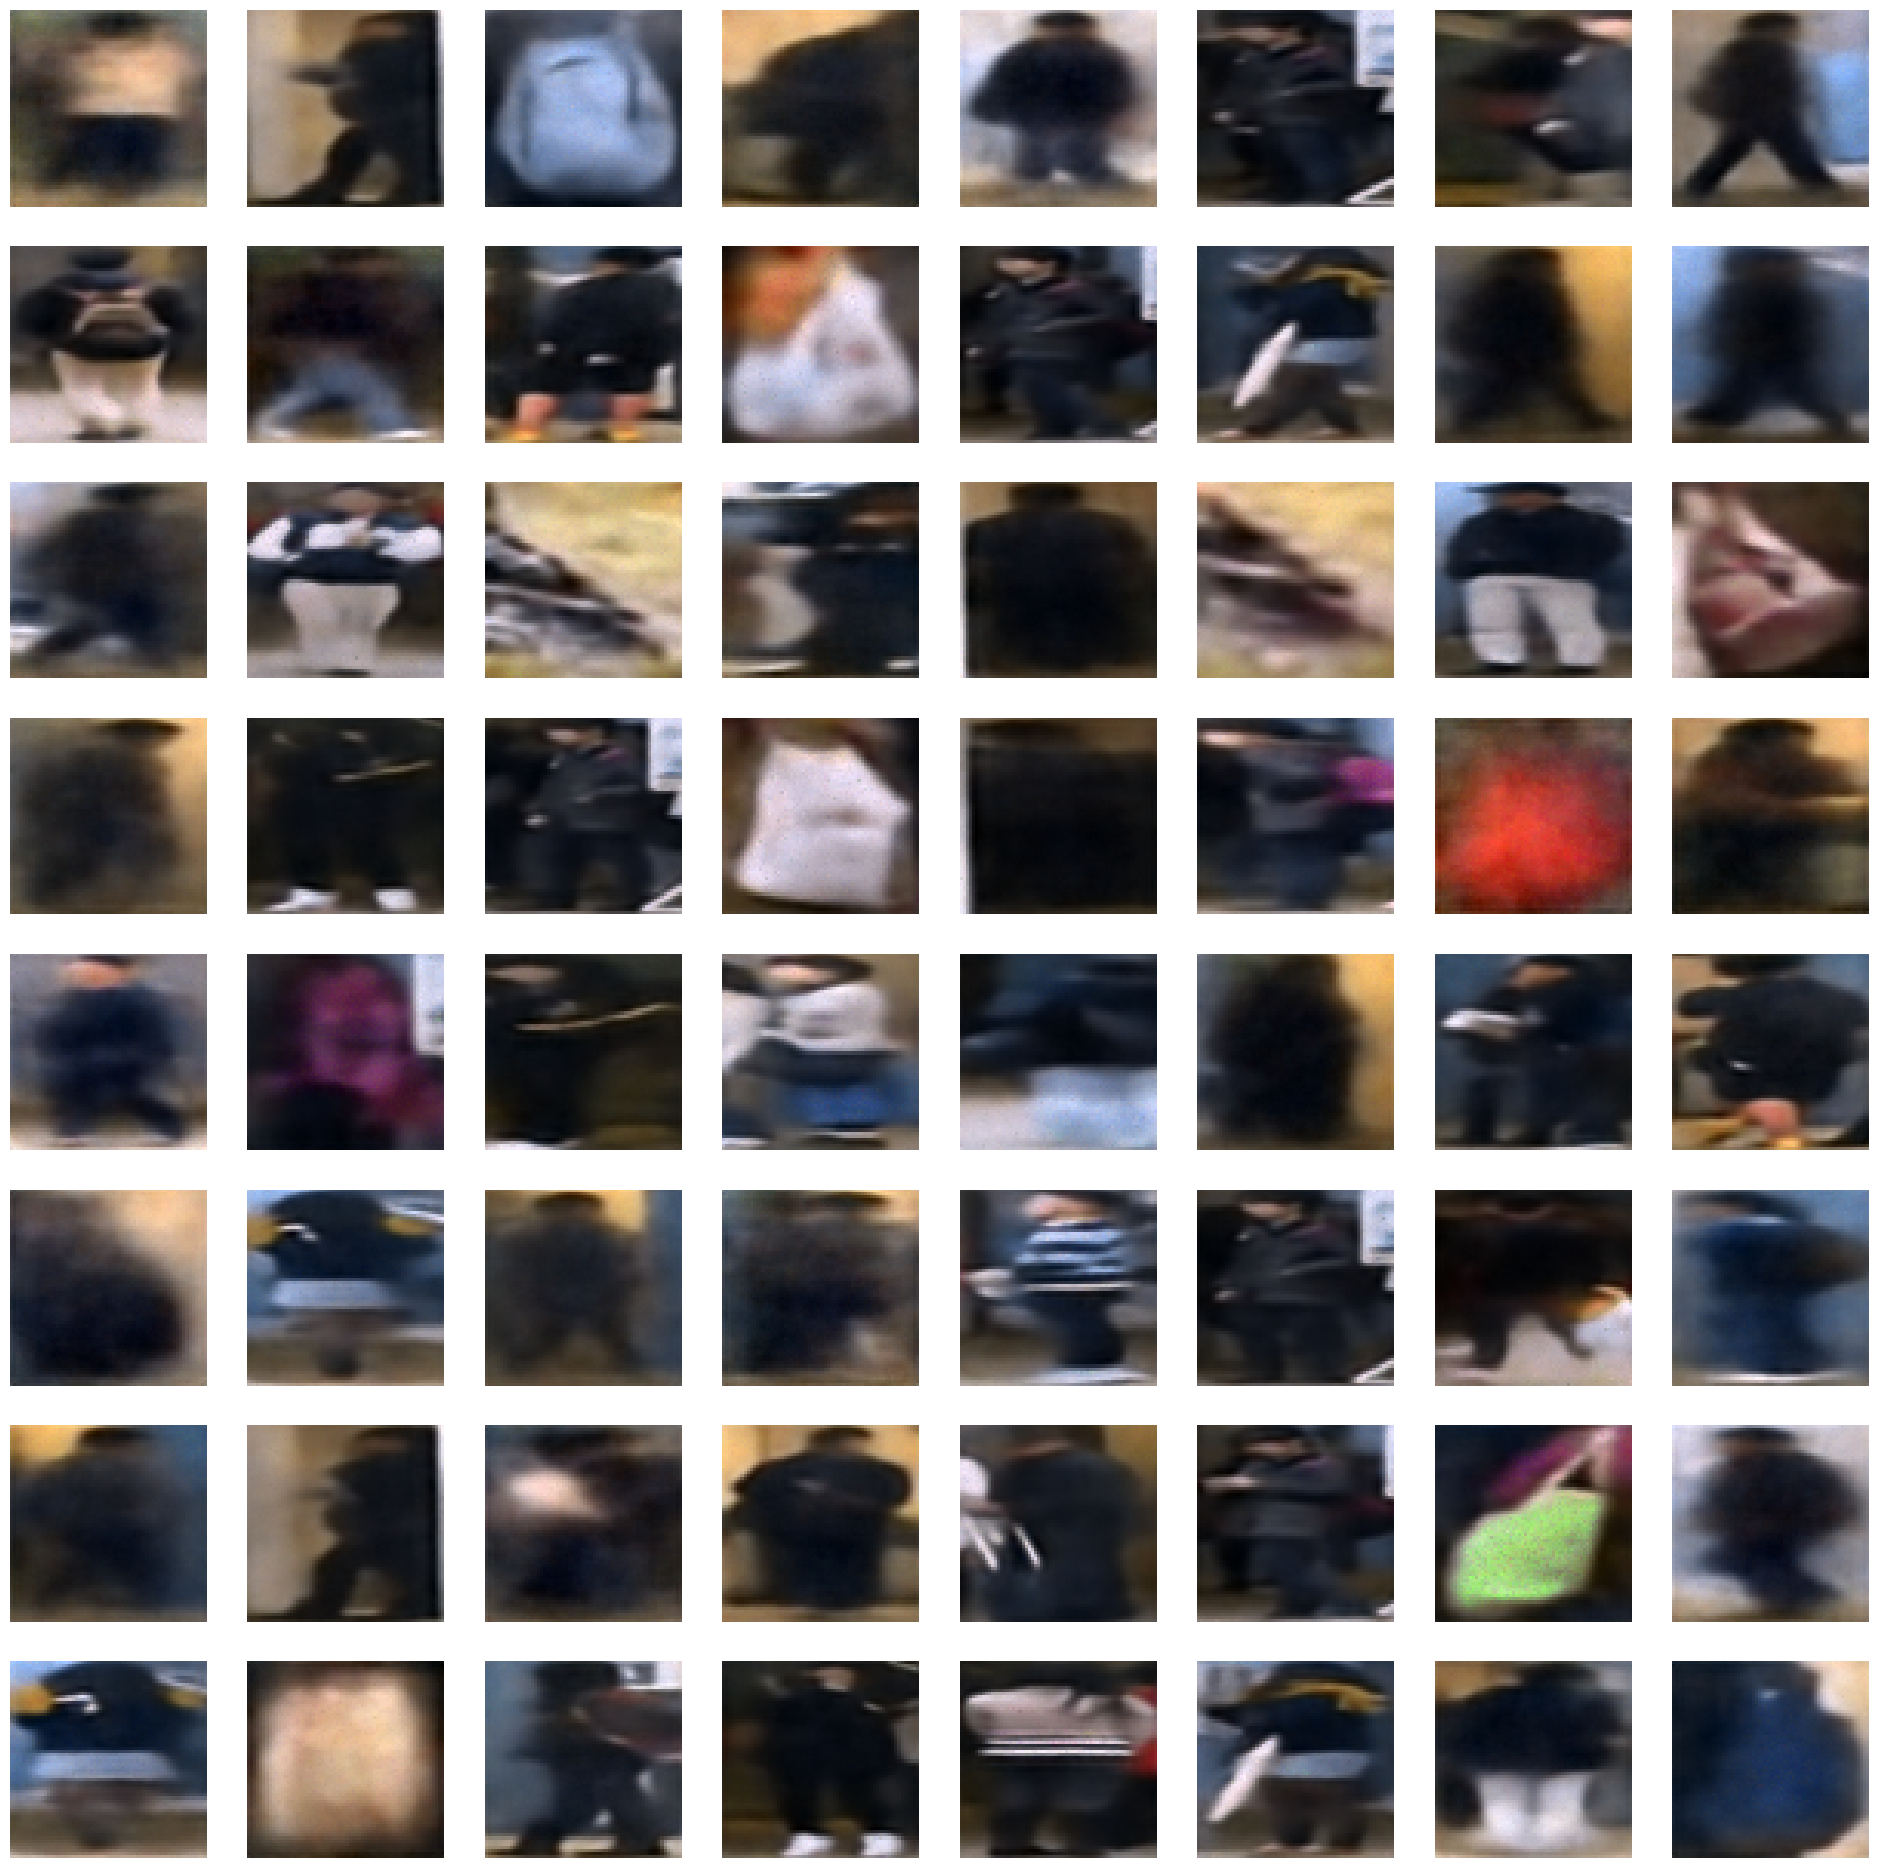

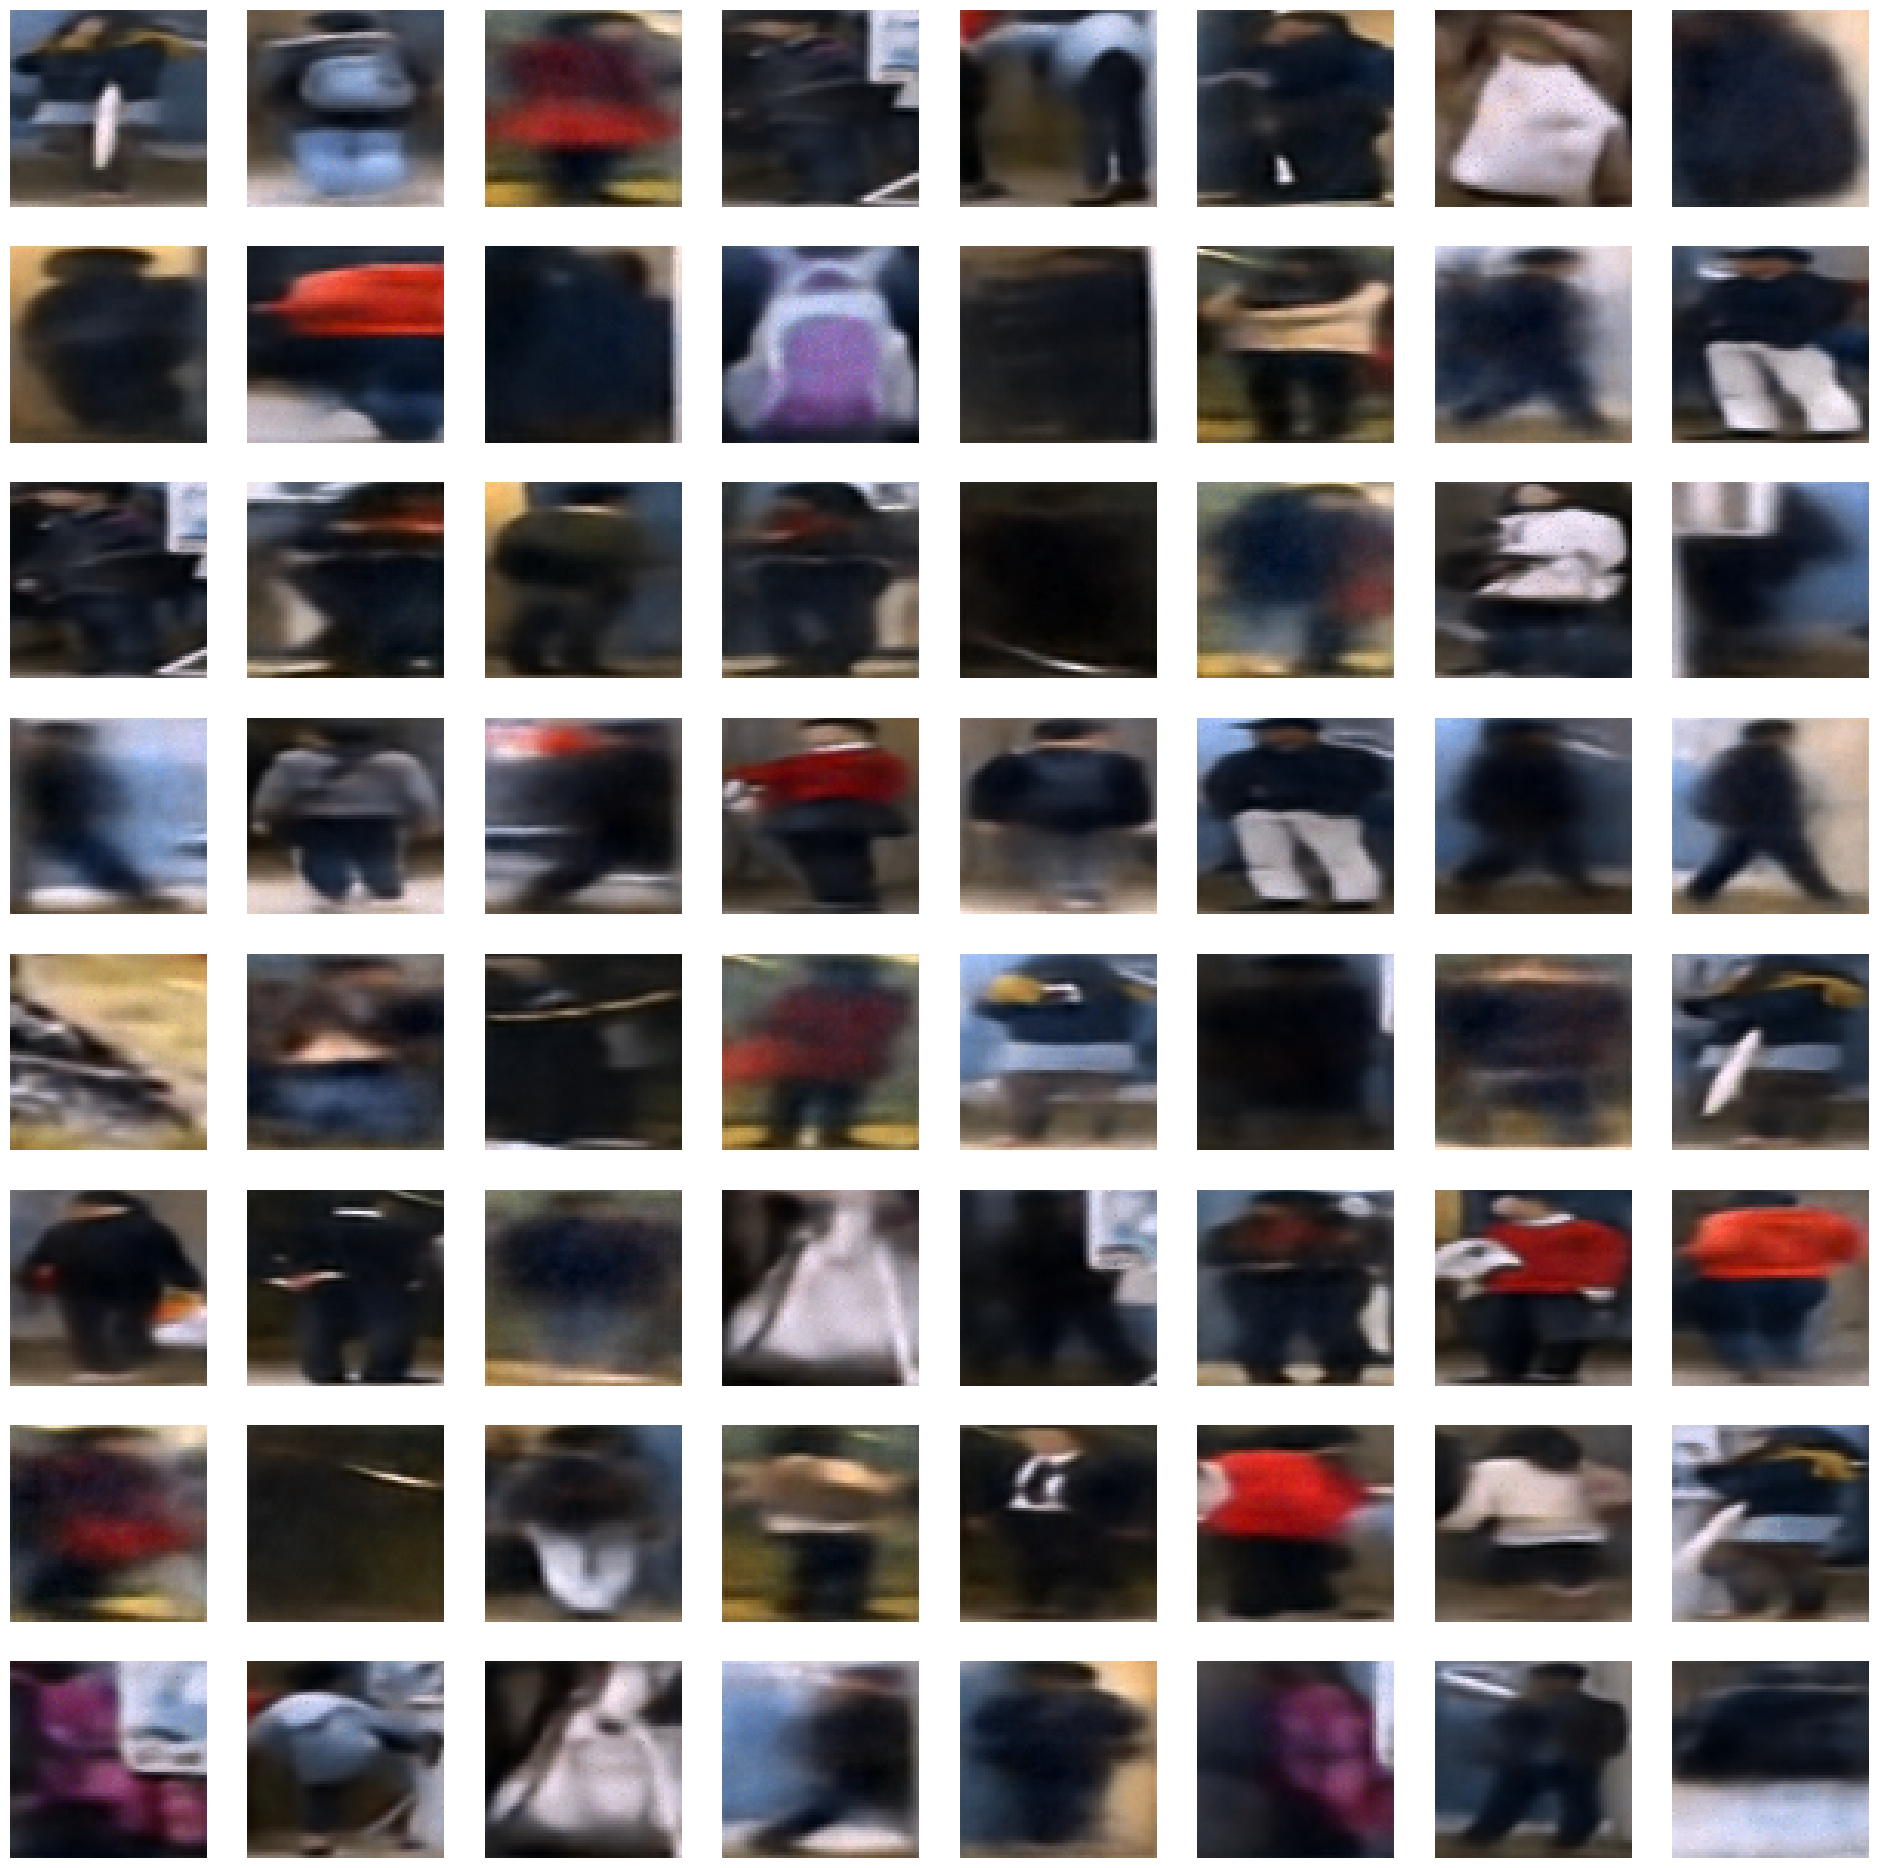

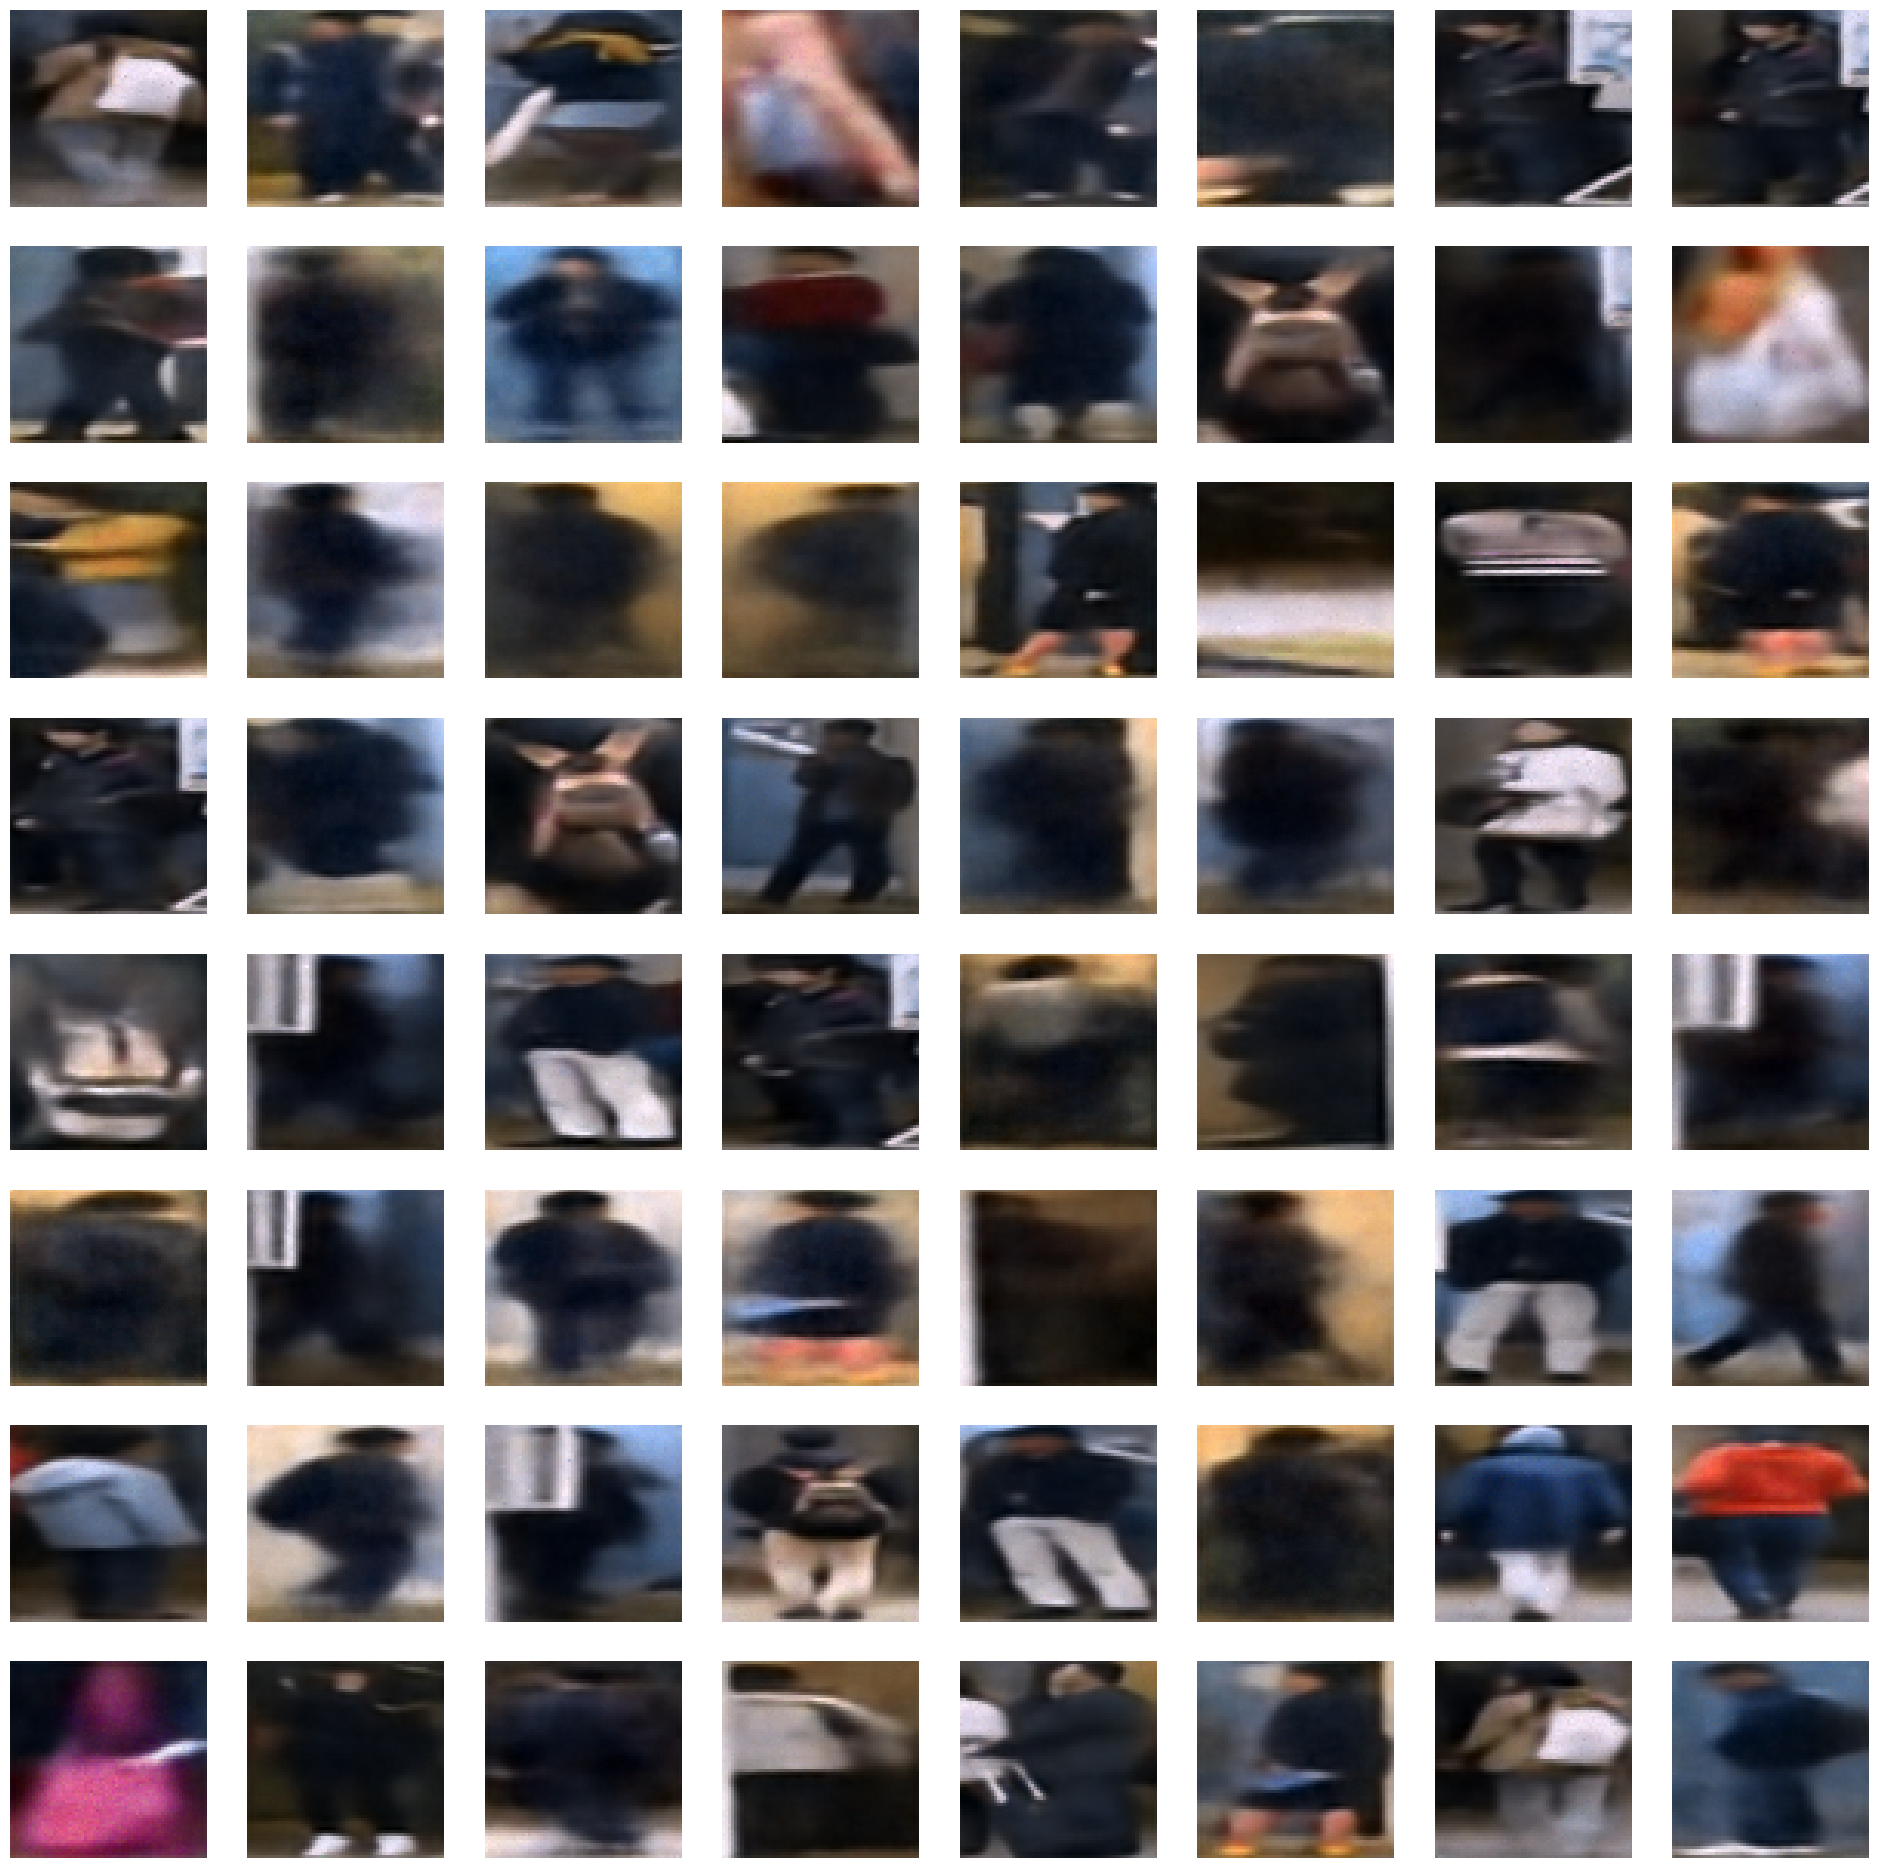

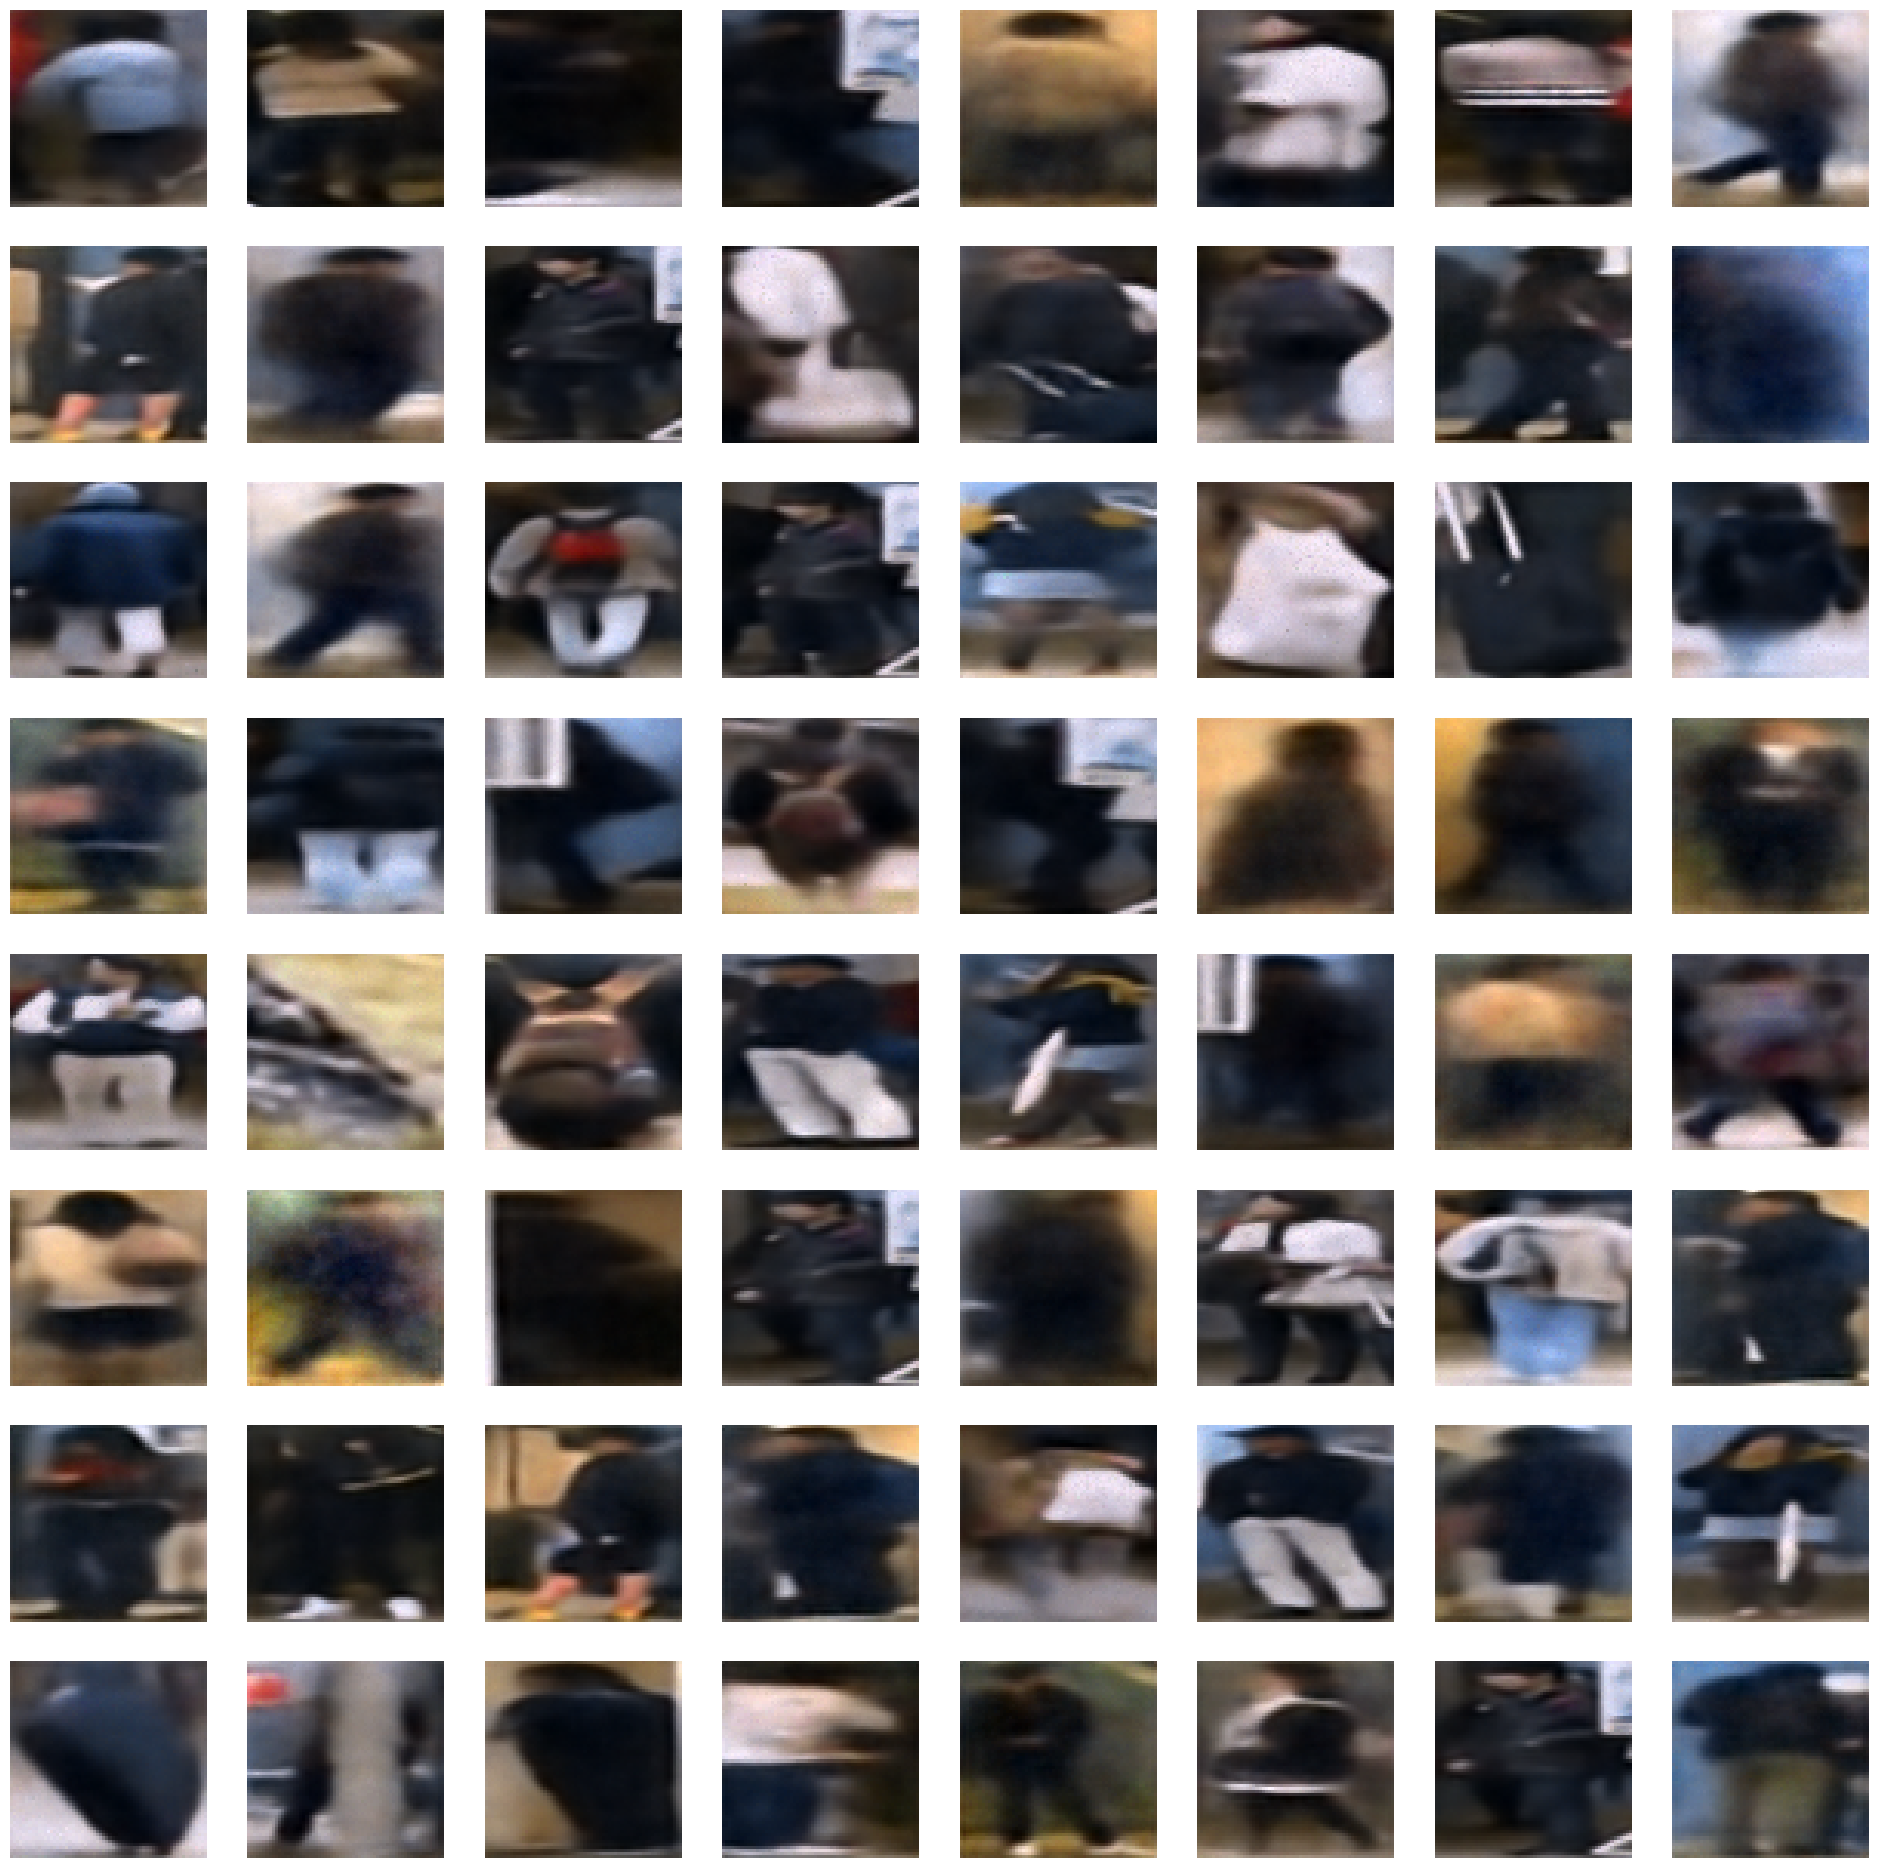

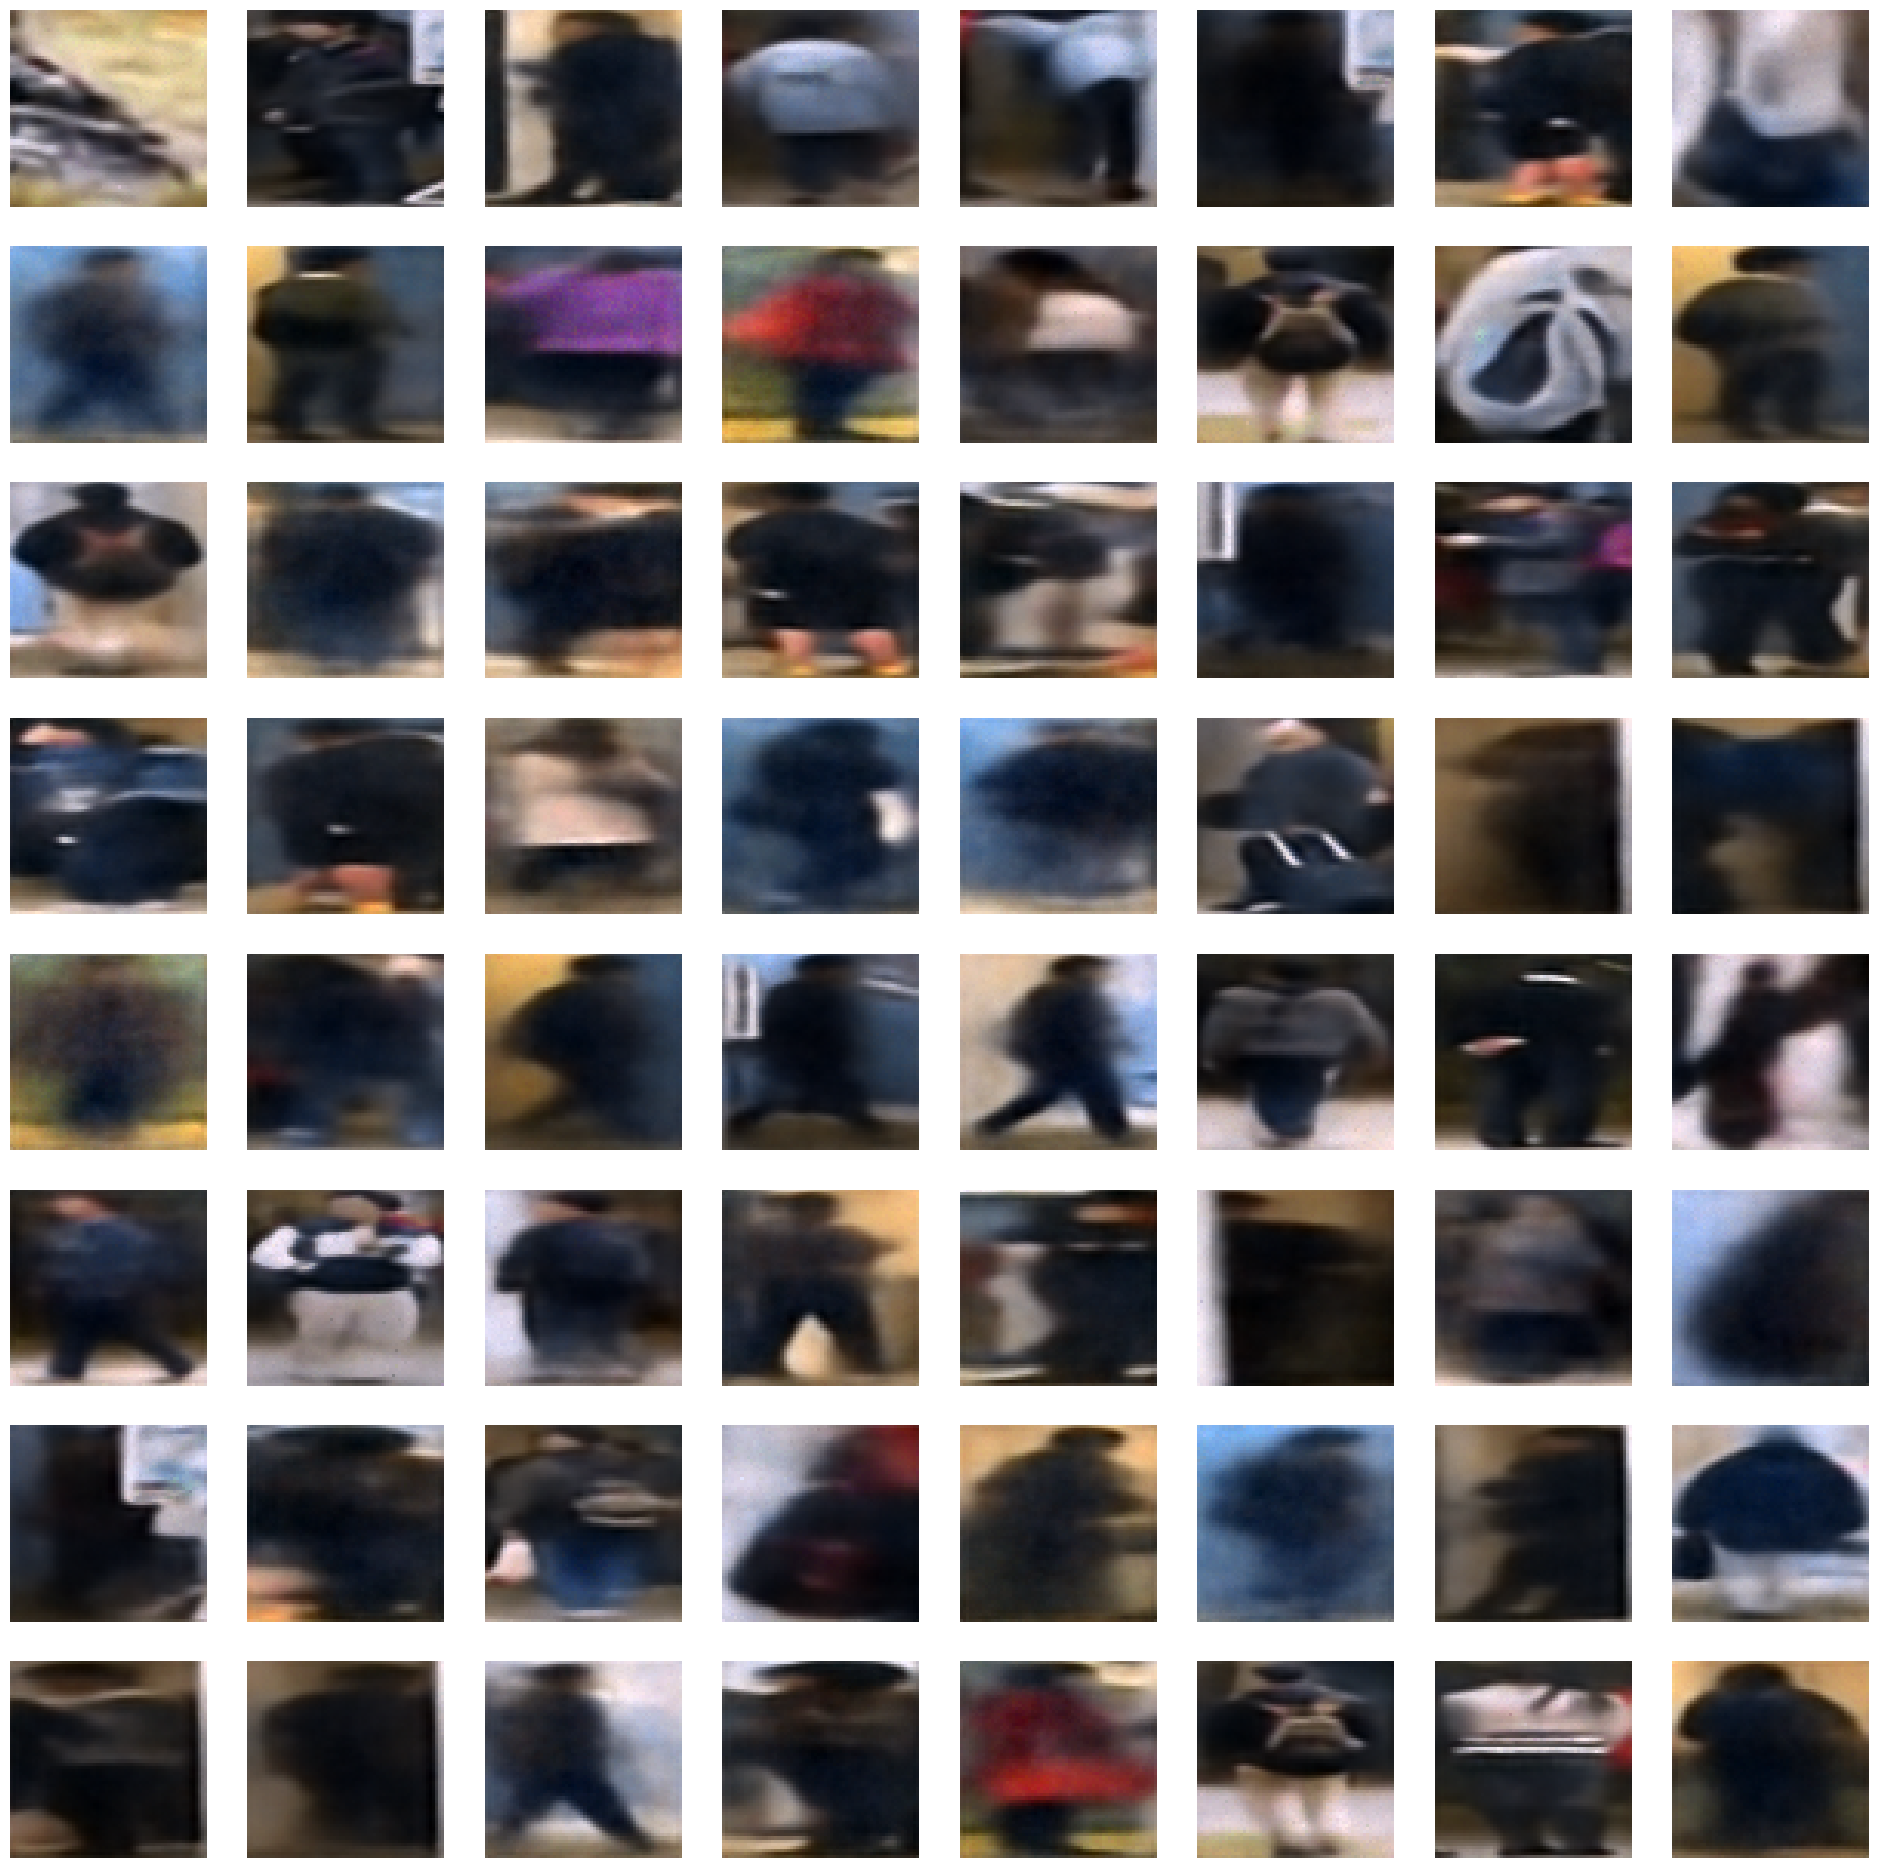

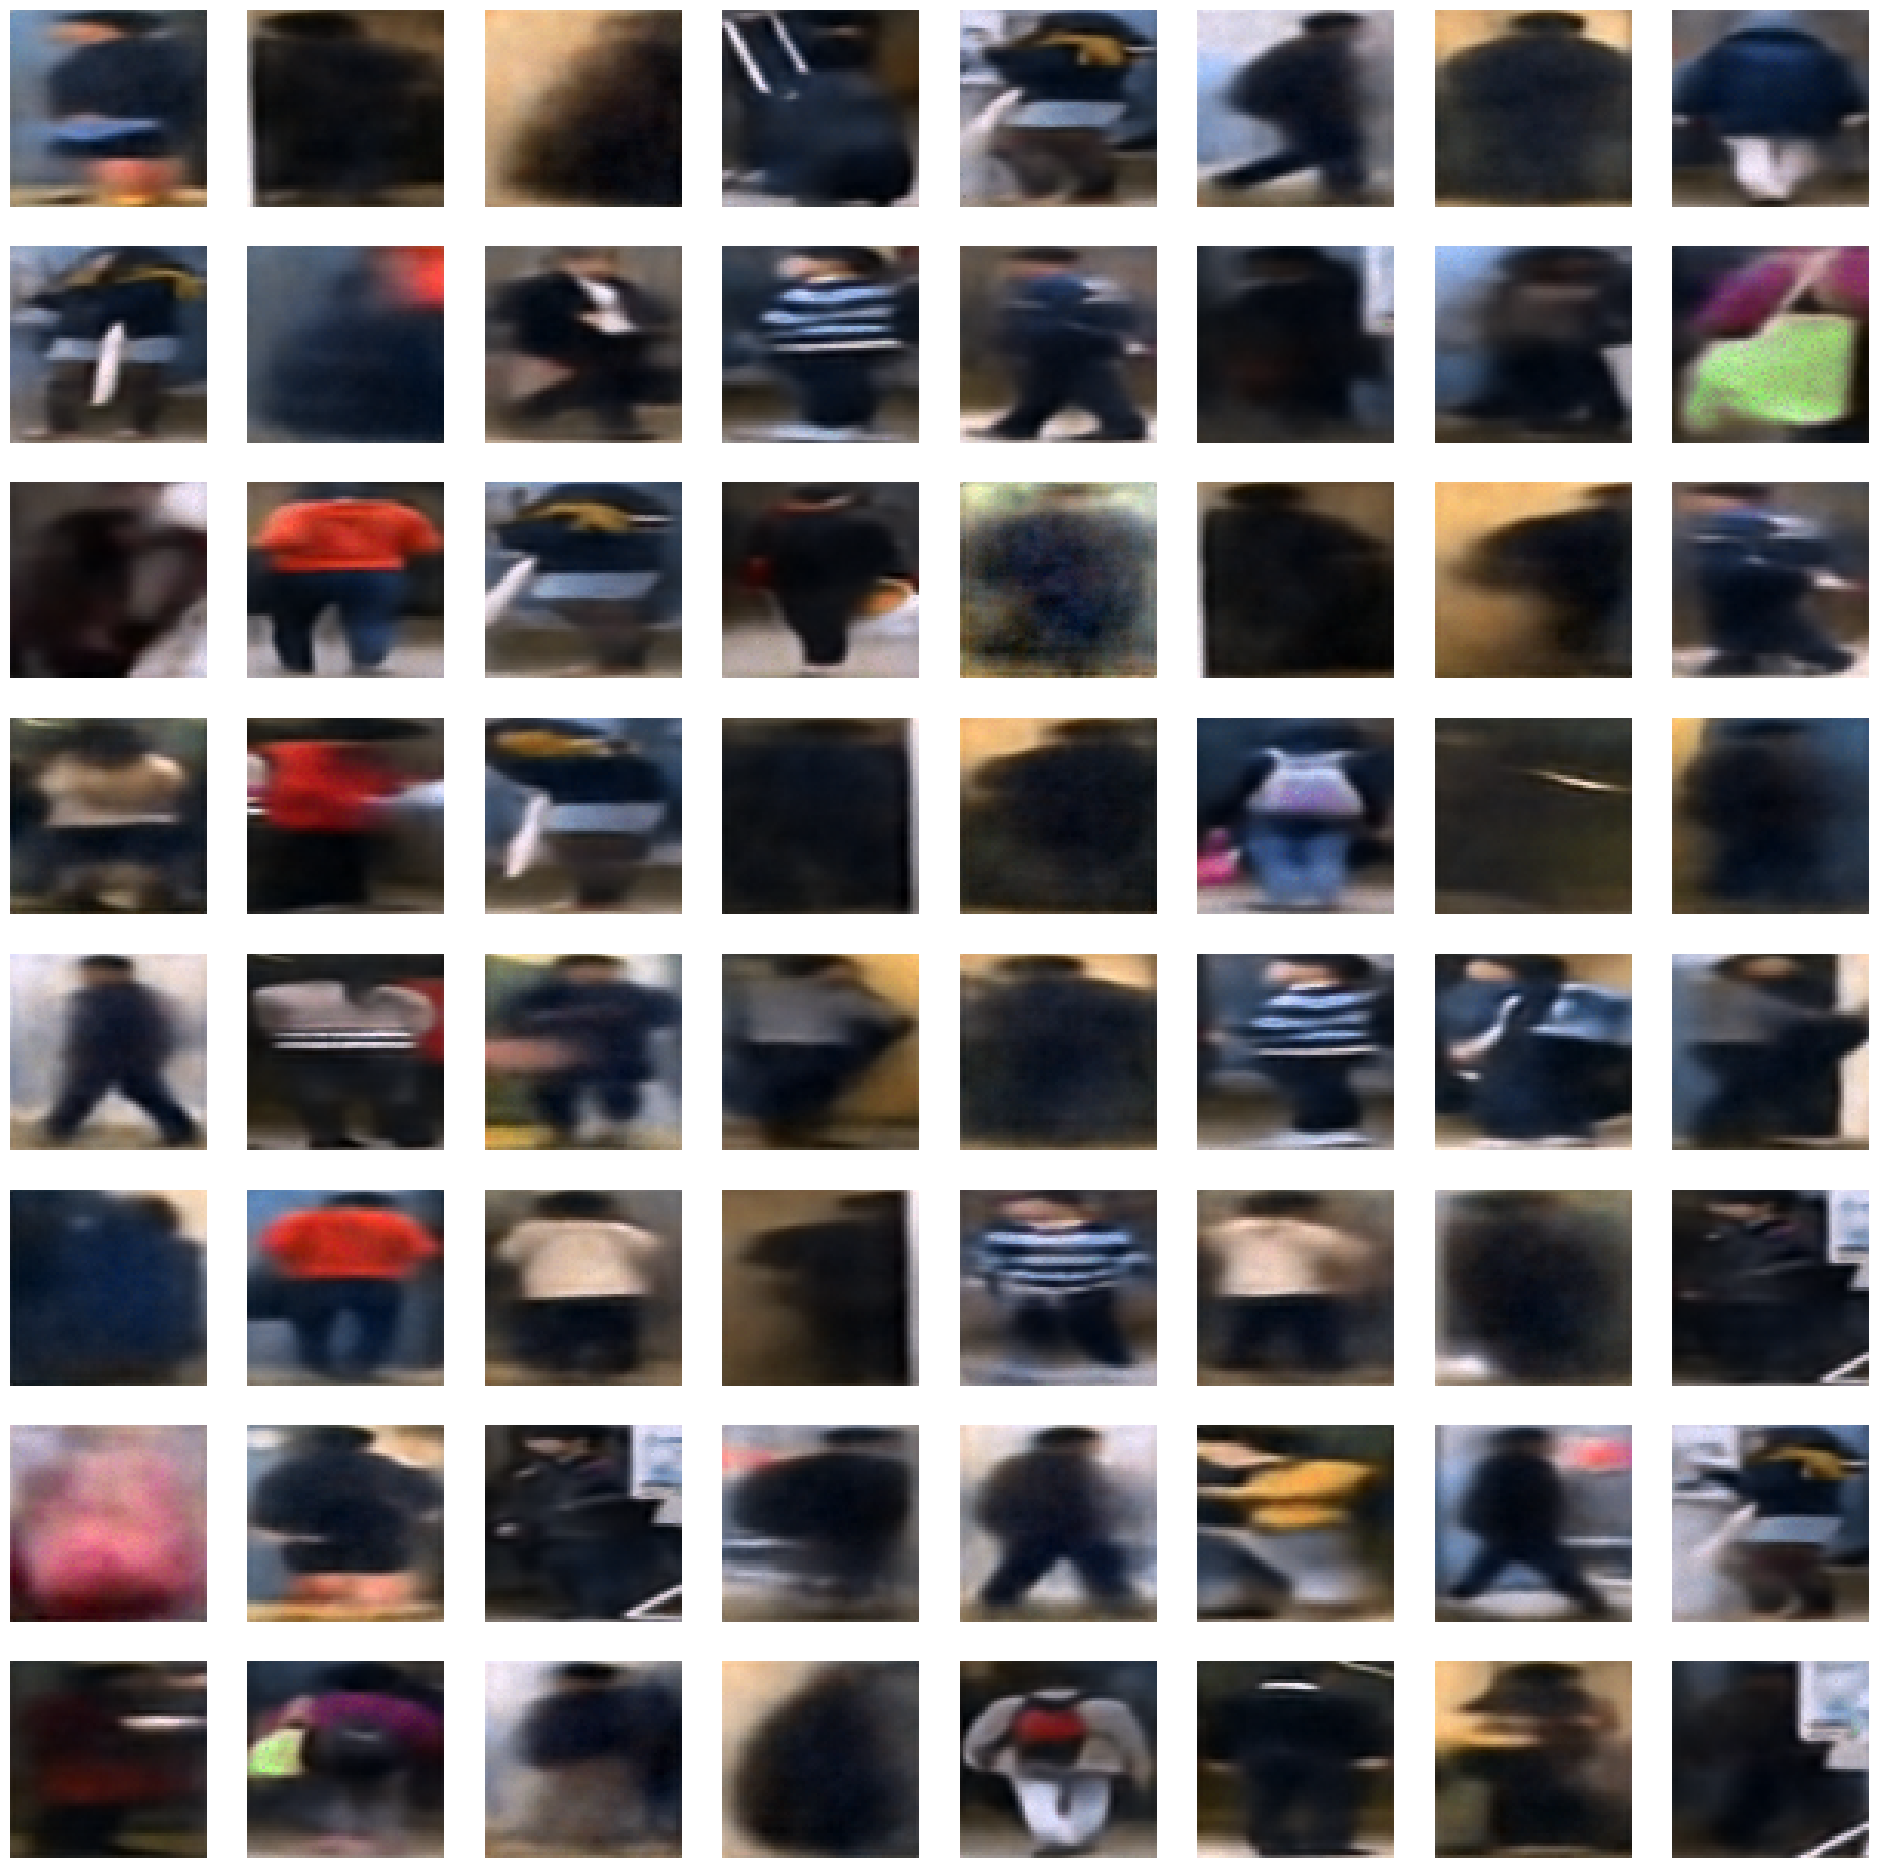

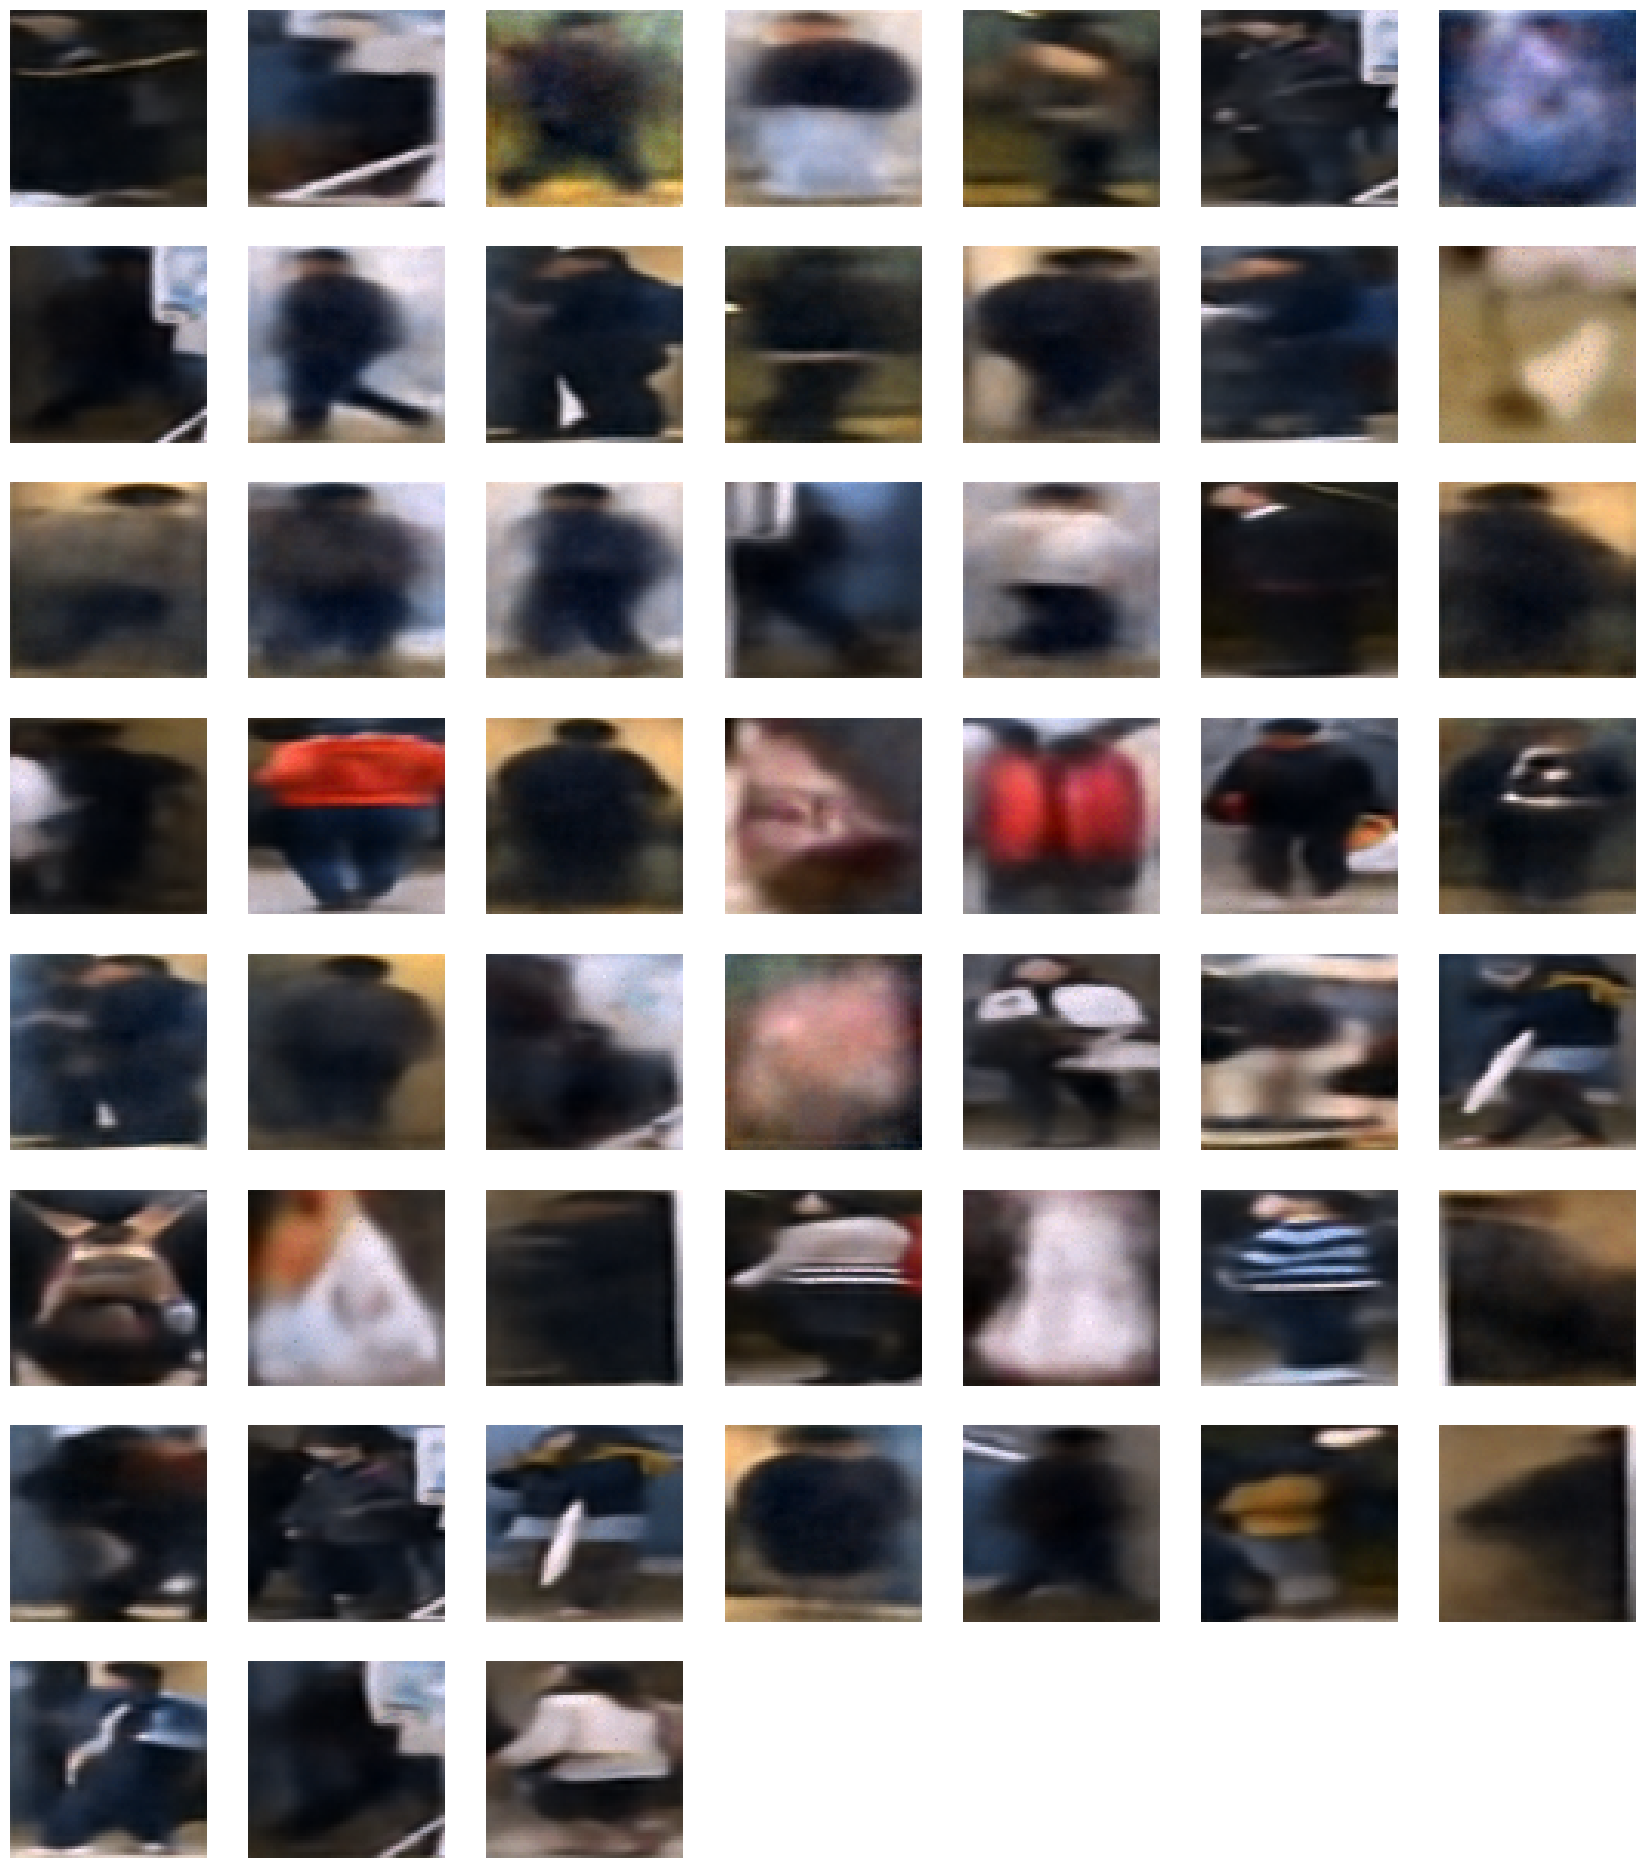

In [97]:
# Initialize Autoencoder
autoencoder_path = "autoencoder_t12_decoder_yolov8_clusters_500_adamw_numheads_8_ffdim_1024_numblocks_2_epoch_8_kmeans_loss_0.0.pth"
encoder.load_state_dict(torch.load(autoencoder_path)["encoder_state_dict"])
decoder.load_state_dict(torch.load(autoencoder_path)["decoder_state_dict"])


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x[-1])
        return x


autoencoder = Autoencoder()
autoencoder = autoencoder.to(device)

# Create Clusters
num_clusters = 500
clusters_name = "avenue_cluster_centers_num_500_2048.pkl"
with open(clusters_name, "rb") as file:
    cluster_centers = pickle.load(file)
cluster_centers_tensor = torch.Tensor(cluster_centers).float().to(device)
print(cluster_centers_tensor.shape)
reshaped_clusters = cluster_centers_tensor.view(500, 512, 2, 2)

# Define batch size
batch_size = 64

# Iterate through reshaped clusters in batches
for i in range(0, len(reshaped_clusters), batch_size):
    batch = reshaped_clusters[i : i + batch_size]

    # Pass the batch through the decoder
    with torch.no_grad():
        reconstructed_clusters = autoencoder.decoder(batch)

        # Visualize each reconstructed cluster separately
        # for img in reconstructed_clusters:
        #     visualize_image(img)
        visualize_batch(reconstructed_clusters)

### Shanghaitech Autoencoder

In [29]:
# Shanghaitech
# autoencoder_path = 'shanghaitech_autoencoder_t12_decoder_yolov8_2_adamw_numheads_8_ffdim_2048_numblocks_1_epoch_17_mseloss_0.0027697434455824254.pth'
# autoencoder_path = 'shanghaitech_autoencoder_t12_decoder_yolov8_2_adamw_numheads_8_ffdim_2048_numblocks_2_epoch_20_mseloss_0.0023662329358668144.pth'

### UBNormal Autoencoder

In [19]:
autoencoder_path = "ubnormal_autoencoder_t12_decoder_yolov8_adamw_numheads_8_ffdim_2048_numblocks_2_epoch_29_mseloss_0.005403553107745176.pth"

## Import Object Detection (bounding boxes) dictionaries for Ground Truth vs Prediction evaluations

### Avenue Obj Dect

In [9]:
# # Read obj_det_avenue_test
# # obj_detections_pkl_path = 'obj_dect_avenue_yolov8_conf_084'
obj_detections_and_optical_flow_pkl_path = (
    "obj_dect_0.86_avenue_optical_flow_raft_thresh_200_minarea_200_iou_0.8"
)
obj_dect_avenue = load_artefact(obj_detections_and_optical_flow_pkl_path)

### Shanghaitech Obj Dect

In [32]:
# obj_detections_and_optical_flow_pkl_path = 'obj_dect_shanghaitech_yolov8_v8_conf_035_retina'
# obj_detections_and_optical_flow_pkl_path = 'obj_dect_shanghaitech_yolov8_v8_conf_06_retina' # This is next
# obj_detections_and_optical_flow_pkl_path = 'obj_dect_08_retina_shanghaitech_optical_flow_raft_thresh_0_minarea_0_lookahead_4_iou_08'
# with open(obj_detections_and_optical_flow_pkl_path, 'rb') as file:
#     obj_dect_avenue = pickle.load(file)

### UBnormal Obj Dect

In [43]:
# obj_detections_and_optical_flow_pkl_path = 'obj_dect_ubnormal_yolov8_conf_085'
# obj_detections_and_optical_flow_pkl_path = 'obj_dect_080_yolov8_ubnormal_optical_flow_raft_thresh_0_minarea_1000_lookahead_3_iou_08'
# with open(obj_detections_and_optical_flow_pkl_path, 'rb') as file:
#     obj_dect_avenue = pickle.load(file)

## Compute RBDC, TBDC, AUC

#### Cluster Loss

In [40]:
# %%time
autoencoder.eval()
all_pred_ano = []
anomaly_scores_dict = {}
for i, video_path in enumerate(test_video_paths):
    print(video_path)
    image_names = [img.split("/")[-1] for img in list_image_files(test_video_paths[i])]

    # Get dict containing {frame_idx: bounding boxes} for current video
    bbox_temp = obj_dect_avenue[video_names[i]]

    # For each video, all frames will have an associated anomaly score given by the max MLE loss on all objects in that frame
    anomaly_scores_dict[video_names[i]] = {}

    # Iterate through
    for frame_idx, image_name in zip(bbox_temp, image_names):
        # Get full path to frame/image
        full_image_path = os.path.join(test_video_paths[i], image_name)

        image = Image.open(full_image_path)

        # Get list of bounding boxes
        boxes = bbox_temp[frame_idx]

        current_frame_max_anomaly_score = float("-inf")

        # Initialize a numpy array of zerios, size of image
        frame_anomaly_map = np.zeros(
            image.size[::-1]
        )  # Image.size returns (width, height)

        # Go through all bounding boxes of that frame, and crop the objects
        for bbox in boxes:
            cropped_obj = image.crop((bbox[0], bbox[1], bbox[2], bbox[3]))

            # Plot the cropped object for debugging
            # cropped_obj.show()  # This will display the cropped image

            # Transform cropped obj to desired 64 * 64 shape
            transformed_obj = autoencoder_transform(cropped_obj)

            # Ensure the transformed object is in the right shape for the model
            transformed_obj = transformed_obj.unsqueeze(0)  # Add batch dimension

            with torch.no_grad():
                # Get the latent representation of our current object
                latent_representation = autoencoder.encoder(transformed_obj.to(device))[
                    -1
                ]  # Assuming the last output is the latent representation

                # Get the last layer and flatten it (this is our latent layer)
                flattened_last = (
                    latent_representation.clone()
                    .view(latent_representation.size(0), -1)
                    .detach()
                    .cpu()
                    .numpy()
                )

                # Create label prediction using K-Means trained on train data
                label = kmeans.predict(flattened_last)

                # Get corresponding centroid for that training sample
                corresponding_centroid = cluster_centers_tensor[label]
                # corresponding_centroid_reshaped = corresponding_centroid.view(1, 512, 2, 2)

                cluster_loss = criterion(
                    latent_representation,
                    corresponding_centroid.view(1, 512, 2, 2).to(device),
                )

                # Reconstruct the centroid assigned
                # reconstructed_centroid = autoencoder.decoder(corresponding_centroid_reshaped)

                # Get reconstructed image
                # reconstructed_img = autoencoder.decoder(latent_representation)

                # # Ensure cropped_obj is a tensor and in the correct shape for loss calculation
                # cropped_obj_tensor = autoencoder_transform(cropped_obj)
                # cropped_obj_tensor = cropped_obj_tensor.unsqueeze(0) # Add batch dimension

                # # Compute reconstruction loss
                # reconstruction_loss = criterion(cropped_obj_tensor.to(device), reconstructed_img)

                # # Compute overall error
                # score = cluster_loss + reconstruction_loss

                score = cluster_loss

            # Given a bounding box, add the score obtained above to the corresponding positions numpy array
            # Use bounding box coordinates
            frame_anomaly_map[
                int(bbox[1]) : int(bbox[3]), int(bbox[0]) : int(bbox[2])
            ] += score.item()
            try:
                anomaly_score = frame_anomaly_map[
                    int(bbox[1]) : int(bbox[3]), int(bbox[0]) : int(bbox[2])
                ].max()
                all_pred_ano.append(
                    AnomalyDetection(
                        frame_idx, bbox, anomaly_score, video_names[i], track_id=-1
                    )
                )
            except:
                pass

            # print(score)
        # TODO: Plot Anomaly Frame
        current_frame_max_anomaly_score = np.max(frame_anomaly_map)
        anomaly_scores_dict[video_names[i]][frame_idx] = current_frame_max_anomaly_score

./datasets/Avenue Dataset/test__/01
./datasets/Avenue Dataset/test__/02
./datasets/Avenue Dataset/test__/03
./datasets/Avenue Dataset/test__/04
./datasets/Avenue Dataset/test__/05
./datasets/Avenue Dataset/test__/06
./datasets/Avenue Dataset/test__/07
./datasets/Avenue Dataset/test__/08
./datasets/Avenue Dataset/test__/09
./datasets/Avenue Dataset/test__/10
./datasets/Avenue Dataset/test__/11
./datasets/Avenue Dataset/test__/12
./datasets/Avenue Dataset/test__/13
./datasets/Avenue Dataset/test__/14
./datasets/Avenue Dataset/test__/15
./datasets/Avenue Dataset/test__/16
./datasets/Avenue Dataset/test__/17
./datasets/Avenue Dataset/test__/18
./datasets/Avenue Dataset/test__/19
./datasets/Avenue Dataset/test__/20
./datasets/Avenue Dataset/test__/21


#### Cluster Loss + Reconstruction

In [85]:
# %%time
autoencoder.eval()
all_pred_ano = []
anomaly_scores_dict = {}
for i, video_path in enumerate(test_video_paths):
    print(video_path)
    image_names = [img.split("/")[-1] for img in list_image_files(test_video_paths[i])]

    # Get dict containing {frame_idx: bounding boxes} for current video
    bbox_temp = obj_dect_avenue[video_names[i]]

    # For each video, all frames will have an associated anomaly score given by the max MLE loss on all objects in that frame
    anomaly_scores_dict[video_names[i]] = {}

    # Iterate through
    for frame_idx, image_name in zip(bbox_temp, image_names):
        # Get full path to frame/image
        full_image_path = os.path.join(test_video_paths[i], image_name)

        image = Image.open(full_image_path)

        # Get list of bounding boxes
        boxes = bbox_temp[frame_idx]

        current_frame_max_anomaly_score = float("-inf")

        # Initialize a numpy array of zerios, size of image
        frame_anomaly_map = np.zeros(
            image.size[::-1]
        )  # Image.size returns (width, height)

        # Go through all bounding boxes of that frame, and crop the objects
        for bbox in boxes:
            cropped_obj = image.crop((bbox[0], bbox[1], bbox[2], bbox[3]))

            # Plot the cropped object for debugging
            # cropped_obj.show()  # This will display the cropped image

            # Transform cropped obj to desired 64 * 64 shape
            transformed_obj = autoencoder_transform(cropped_obj)

            # Ensure the transformed object is in the right shape for the model
            transformed_obj = transformed_obj.unsqueeze(0)  # Add batch dimension

            with torch.no_grad():
                # Get the latent representation of our current object
                latent_representation = autoencoder.encoder(transformed_obj.to(device))[
                    -1
                ]  # Assuming the last output is the latent representation

                # Get the last layer and flatten it (this is our latent layer)
                flattened_last = (
                    latent_representation.clone()
                    .view(latent_representation.size(0), -1)
                    .detach()
                    .cpu()
                    .numpy()
                )

                # Create label prediction using K-Means trained on train data
                label = kmeans.predict(flattened_last)

                # Get corresponding centroid for that training sample
                corresponding_centroid = cluster_centers_tensor[label]
                corresponding_centroid_reshaped = corresponding_centroid.view(
                    1, 512, 2, 2
                )

                cluster_loss = criterion(
                    latent_representation,
                    corresponding_centroid.view(1, 512, 2, 2).to(device),
                )

                # Reconstruct the centroid assigned
                reconstructed_centroid = autoencoder.decoder(
                    corresponding_centroid_reshaped
                )

                # Get reconstructed image
                reconstructed_img = autoencoder.decoder(latent_representation)

                # Ensure cropped_obj is a tensor and in the correct shape for loss calculation
                cropped_obj_tensor = autoencoder_transform(cropped_obj)
                cropped_obj_tensor = cropped_obj_tensor.unsqueeze(
                    0
                )  # Add batch dimension

                # Compute reconstruction loss
                reconstruction_loss = criterion(
                    cropped_obj_tensor.to(device), reconstructed_img
                )

                # Compute overall error
                score = cluster_loss + reconstruction_loss

            # Given a bounding box, add the score obtained above to the corresponding positions numpy array
            # Use bounding box coordinates
            frame_anomaly_map[
                int(bbox[1]) : int(bbox[3]), int(bbox[0]) : int(bbox[2])
            ] += score.item()
            try:
                anomaly_score = frame_anomaly_map[
                    int(bbox[1]) : int(bbox[3]), int(bbox[0]) : int(bbox[2])
                ].max()
                all_pred_ano.append(
                    AnomalyDetection(
                        frame_idx, bbox, anomaly_score, video_names[i], track_id=-1
                    )
                )
            except:
                pass

            # print(score)
        # TODO: Plot Anomaly Frame
        current_frame_max_anomaly_score = np.max(frame_anomaly_map)
        anomaly_scores_dict[video_names[i]][frame_idx] = current_frame_max_anomaly_score

./datasets/Avenue Dataset/test__/01
./datasets/Avenue Dataset/test__/02
./datasets/Avenue Dataset/test__/03
./datasets/Avenue Dataset/test__/04
./datasets/Avenue Dataset/test__/05
./datasets/Avenue Dataset/test__/06
./datasets/Avenue Dataset/test__/07
./datasets/Avenue Dataset/test__/08
./datasets/Avenue Dataset/test__/09
./datasets/Avenue Dataset/test__/10
./datasets/Avenue Dataset/test__/11
./datasets/Avenue Dataset/test__/12
./datasets/Avenue Dataset/test__/13
./datasets/Avenue Dataset/test__/14
./datasets/Avenue Dataset/test__/15
./datasets/Avenue Dataset/test__/16
./datasets/Avenue Dataset/test__/17
./datasets/Avenue Dataset/test__/18
./datasets/Avenue Dataset/test__/19
./datasets/Avenue Dataset/test__/20
./datasets/Avenue Dataset/test__/21


#### MSE Reconstruction

In [10]:
anomaly_scores_dict, all_pred_ano = compute_anomaly_reconstruction_scores(
    autoencoder=autoencoder,
    obj_dect_dict=obj_dect_avenue,
    test_video_paths=test_video_paths,
    video_names=video_names,
    device=device,
)

./datasets/Avenue Dataset/test__/01
./datasets/Avenue Dataset/test__/02
./datasets/Avenue Dataset/test__/03
./datasets/Avenue Dataset/test__/04
./datasets/Avenue Dataset/test__/05
./datasets/Avenue Dataset/test__/06
./datasets/Avenue Dataset/test__/07
./datasets/Avenue Dataset/test__/08
./datasets/Avenue Dataset/test__/09
./datasets/Avenue Dataset/test__/10
./datasets/Avenue Dataset/test__/11
./datasets/Avenue Dataset/test__/12
./datasets/Avenue Dataset/test__/13
./datasets/Avenue Dataset/test__/14
./datasets/Avenue Dataset/test__/15
./datasets/Avenue Dataset/test__/16
./datasets/Avenue Dataset/test__/17
./datasets/Avenue Dataset/test__/18
./datasets/Avenue Dataset/test__/19
./datasets/Avenue Dataset/test__/20
./datasets/Avenue Dataset/test__/21


#### Compute TBDC, RBDC

In [11]:
print(num_tracks, num_frames)

121 15324


In [12]:
compute_fpr_rbdr(
    all_pred_ano,
    gt_anomalies,
    all_gt_tracks,
    num_frames=num_frames,
    num_tracks=num_tracks,
)

tbdc = 0.516174056360573
rbdc = 0.617622995152767


(0.617622995152767, 0.516174056360573)

#### Dummy run with random score to view baseline

In [78]:
# %%time
# all_pred_ano = []
# anomaly_scores_dict = {}
# for i, video_path in enumerate(test_video_paths):
#     print(video_path)
#     image_names = [img.split('/')[-1] for img in list_image_files(test_video_paths[i])]

#     # Get dict containing {frame_idx: bounding boxes} for current video
#     bbox_temp = obj_dect_avenue[video_names[i]]

#     # For each video, all frames will have an associated anomaly score given by the max MLE loss on all objects in that frame
#     anomaly_scores_dict[video_names[i]] = {}

#     # Iterate through
#     for frame_idx, image_name in zip(bbox_temp, image_names):

#         # Get full path to frame/image
#         full_image_path = os.path.join(test_video_paths[i], image_name)

#         image = Image.open(full_image_path)

#         # Get list of bounding boxes
#         boxes = bbox_temp[frame_idx]

#         # current_frame_max_anomaly_score = float('-inf')

#         # # Go through all bounding boxes of that frame, and crop the objects
#         # for bbox in boxes:
#         #     cropped_obj = image.crop((bbox[0], bbox[1], bbox[2], bbox[3]))

#         #     # Plot the cropped object for debugging
#         #     # cropped_obj.show()  # This will display the cropped image

#         #     # TODO: Transform cropped obj to desired 64 * 64 shape
#         #     transformed_obj = autoencoder_transform(cropped_obj)

#         #     # Ensure the transformed object is in the right shape for the model
#         #     transformed_obj = transformed_obj.unsqueeze(0)  # Add batch dimension

#         #     with torch.no_grad():
#         #         # Forward pass through the encoder and then the decoder
#         #         latent_representation = encoder(transformed_obj.to(device))[-1]  # Assuming the last output is the latent representation
#         #         reconstructed_img = decoder(latent_representation)

#         #     # Ensure cropped_obj is a tensor and in the correct shape for loss calculation
#         #     cropped_obj_tensor = autoencoder_transform(cropped_obj)
#         #     cropped_obj_tensor = cropped_obj_tensor.unsqueeze(0) # Add batch dimension

#         #     # Compute the reconstruction loss
#         #     # score = F.mse_loss(reconstructed_img, cropped_obj_tensor.to(device))
#         #     score = random.random()

#         #     # We want to store the max anomaly score for this frame
#         #     current_frame_max_anomaly_score = max(score, current_frame_max_anomaly_score)

#         #     # print(score)

#         score = random.random()

#         # We should now have bounding box, frame idx, maximum anomaly score,
#         all_pred_ano.append(AnomalyDetection(frame_idx, bbox, score, video_names[i], track_id=-1))

#         anomaly_scores_dict[video_names[i]][frame_idx] = score

In [79]:
compute_fpr_rbdr(
    all_pred_ano, gt_anomalies, all_gt_tracks, num_frames=15324, num_tracks=num_tracks
)

tbdc = 0.36928838466533354
rbdc = 0.6459050511339665


(0.6459050511339665, 0.36928838466533354)

#### Save and load to pickle

In [ ]:
# # Save the object to a file
# with open(pickle_file, 'wb') as file:
#     pickle.dump(all_pred_ano, file)

In [ ]:
# # Load the object from the file
# pickle_file = 'all_pred_ano_avenue_v3.pkl'
# with open(pickle_file, 'rb') as file:
#     all_pred_ano = pickle.load(file)

## Micro / Macro AUC Score

#### Shanghaitech

In [37]:
labels_path = "./datasets/shanghaitech/testing/test_frame_mask/"
labels_dict = {}
for vid_name in anomaly_scores_dict:
    labels_dict[vid_name] = np.load(os.path.join(labels_path, f"{vid_name}.npy"))
print(labels_dict.keys())

dict_keys(['01_0014', '01_0015', '01_0016', '01_0025', '01_0026', '01_0027', '01_0028', '01_0029', '01_0030', '01_0051', '01_0052', '01_0053', '01_0054', '01_0055', '01_0056', '01_0063', '01_0064', '01_0073', '01_0076', '01_0129', '01_0130', '01_0131', '01_0132', '01_0133', '01_0134', '01_0135', '01_0136', '01_0138', '01_0139', '01_0140', '01_0141', '01_0162', '01_0163', '01_0177', '02_0128', '02_0161', '02_0164', '03_0031', '03_0032', '03_0033', '03_0035', '03_0036', '03_0039', '03_0041', '03_0059', '03_0060', '03_0061', '04_0001', '04_0003', '04_0004', '04_0010', '04_0011', '04_0012', '04_0013', '04_0046', '04_0050', '05_0017', '05_0018', '05_0019', '05_0020', '05_0021', '05_0022', '05_0023', '05_0024', '06_0144', '06_0145', '06_0147', '06_0150', '06_0153', '06_0155', '07_0005', '07_0006', '07_0007', '07_0008', '07_0009', '07_0047', '07_0048', '07_0049', '08_0044', '08_0058', '08_0077', '08_0078', '08_0079', '08_0080', '08_0156', '08_0157', '08_0158', '08_0159', '08_0178', '08_0179',

#### UBNormal

In [48]:
# Save the object to a file
# Import pickle file
import pickle

with open("ubnormal_anomaly_test_labels_masks", "rb") as file:
    labels_dict = pickle.load(file)
# print(labels_dict.keys())

#### Macro & Micro AUC

In [18]:
print("Macro AUC:")
macro_auc, filtered_preds, filtered_labels = compute_macro_auc(
    anomaly_scores_dict, labels_dict
)

print("Micro AUC:")
micro_auc = compute_micro_auc(filtered_preds, filtered_labels)

Macro AUC:
0.8467801007655853
Micro AUC:
0.8673057751001096


### Automatically Run TBDC, RBDC, Macro Micro (at fixed Range, Mu)

In [41]:
filenames = [
    "obj_dect_080_yolov8_ubnormal_optical_flow_raft_thresh_0_minarea_500_lookahead_3_iou_08",
    "obj_dect_080_yolov8_ubnormal_optical_flow_raft_thresh_0_minarea_1000_lookahead_3_iou_08",
    "obj_dect_080_yolov8_ubnormal_optical_flow_raft_thresh_0_minarea_2000_lookahead_3_iou_08",
]

In [42]:
from tqdm import tqdm

for filename in tqdm(filenames):
    # Read File
    try:
        with open(filename, "rb") as file:
            obj_dect_avenue = pickle.load(file)
    except:
        print("Could not read: ", filename)
        continue

    print(filename)
    all_pred_ano = []
    anomaly_scores_dict = {}
    for i, video_path in enumerate(test_video_paths):
        # print(video_path)
        image_names = [
            img.split("/")[-1] for img in list_image_files(test_video_paths[i])
        ]

        # Get dict containing {frame_idx: bounding boxes} for current video
        bbox_temp = obj_dect_avenue[video_names[i]]

        # For each video, all frames will have an associated anomaly score given by the max MLE loss on all objects in that frame
        anomaly_scores_dict[video_names[i]] = {}

        # Iterate through
        for frame_idx, image_name in zip(bbox_temp, image_names):
            # Get full path to frame/image
            full_image_path = os.path.join(test_video_paths[i], image_name)

            image = Image.open(full_image_path)

            # Get list of bounding boxes
            boxes = bbox_temp[frame_idx]

            current_frame_max_anomaly_score = float("-inf")

            # Initialize a numpy array of zerios, size of image
            frame_anomaly_map = np.zeros(
                image.size[::-1]
            )  # Image.size returns (width, height)

            # Go through all bounding boxes of that frame, and crop the objects
            for bbox in boxes:
                cropped_obj = image.crop((bbox[0], bbox[1], bbox[2], bbox[3]))

                # Plot the cropped object for debugging
                # cropped_obj.show()  # This will display the cropped image

                # Transform cropped obj to desired 64 * 64 shape
                transformed_obj = autoencoder_transform(cropped_obj)

                # Ensure the transformed object is in the right shape for the model
                transformed_obj = transformed_obj.unsqueeze(0)  # Add batch dimension

                with torch.no_grad():
                    # Forward pass through the encoder and then the decoder
                    # latent_representation = encoder(transformed_obj.to(device))[-1]  # Assuming the last output is the latent representation
                    # reconstructed_img = decoder(latent_representation)
                    reconstructed_img = autoencoder(transformed_obj.to(device))

                # Ensure cropped_obj is a tensor and in the correct shape for loss calculation
                cropped_obj_tensor = autoencoder_transform(cropped_obj)
                cropped_obj_tensor = cropped_obj_tensor.unsqueeze(
                    0
                )  # Add batch dimension

                # Compute the reconstruction loss
                score = F.mse_loss(reconstructed_img, cropped_obj_tensor.to(device))

                # We want to store the max anomaly score for this frame
                # if score > current_frame_max_anomaly_score:
                #     current_frame_max_anomaly_score = score
                #     anomaly_bbox = bbox

                # pentru fiecare frame pun toate obiectele in scena
                # initializez un numpy array cu 0
                # pentru fiecare obiect la bounding box-ul lui, pun MSE loss-ul
                # Suprapun toate obiectele dintr-un frame (prin adaugare/suma)
                # Apoi iau maximul per frame (sa le si plotez) -> frame-urile

                # Given a bounding box, add the score obtained above to the corresponding positions numpy array
                # Use bounding box coordinates
                frame_anomaly_map[
                    int(bbox[1]) : int(bbox[3]), int(bbox[0]) : int(bbox[2])
                ] += score.item()
                try:
                    anomaly_score = frame_anomaly_map[
                        int(bbox[1]) : int(bbox[3]), int(bbox[0]) : int(bbox[2])
                    ].max()
                    all_pred_ano.append(
                        AnomalyDetection(
                            frame_idx, bbox, anomaly_score, video_names[i], track_id=-1
                        )
                    )
                except:
                    pass

                # print(score)
            # TODO: Plot Anomaly Frame
            current_frame_max_anomaly_score = np.max(frame_anomaly_map)
            anomaly_scores_dict[video_names[i]][
                frame_idx
            ] = current_frame_max_anomaly_score

    compute_fpr_rbdr(
        all_pred_ano,
        gt_anomalies,
        all_gt_tracks,
        num_frames=num_frames,
        num_tracks=num_tracks,
    )

    aucs = []
    filtered_preds = []
    filtered_labels = []

    for vid_name in anomaly_scores_dict:
        # print(len(anomaly_scores_dict[vid_name]))
        pred = np.array(list(score for score in anomaly_scores_dict[vid_name].values()))
        pred = process_current_vid_preds(pred)
        filtered_preds.append(pred)

        lbl = labels_dict[vid_name]
        filtered_labels.append(lbl)

        lbl = np.array([0] + list(lbl) + [1])
        pred = np.array([0] + list(pred) + [1])

        fpr, tpr, _ = metrics.roc_curve(lbl, pred)
        res = metrics.auc(fpr, tpr)
        aucs.append(res)

    macro_auc = np.nanmean(aucs)
    print("Macro AUC: ", macro_auc)

    # Micro-AUC
    filtered_preds = np.concatenate(filtered_preds)
    filtered_labels = np.concatenate(filtered_labels)

    fpr, tpr, _ = metrics.roc_curve(filtered_labels, filtered_preds)
    micro_auc = metrics.auc(fpr, tpr)
    micro_auc = np.nan_to_num(micro_auc, nan=1.0)

    print("Micro AUC: ", micro_auc)
    print("---------------------")

  0%|                                                                                             | 0/3 [00:00<?, ?it/s]

obj_dect_080_yolov8_ubnormal_optical_flow_raft_thresh_0_minarea_500_lookahead_3_iou_08


  0%|                                                                                             | 0/3 [20:24<?, ?it/s]

KeyboardInterrupt



### Experiment best Macro and Micro

In [33]:
from tqdm import tqdm

In [34]:
%%time


def filt(input, dim=9, range=502, mu=95):
    filter_3d = np.ones((dim, dim, dim)) / (dim**3)
    filter_2d = gaussian_filter(np.arange(1, range), mu)

    frame_scores = input  # This works
    # frame_scores = convolve(input, filter_3d)
    # frame_scores = frame_scores.max((1, 2))

    padding_size = len(filter_2d) // 2
    in_ = np.concatenate((np.zeros(padding_size), frame_scores, np.zeros(padding_size)))
    frame_scores = np.correlate(in_, filter_2d, "valid")
    return frame_scores


def process_current_vid_preds(pred: np.array, range=502, mu=95):
    pred = np.nan_to_num(pred, nan=0.0)
    pred = filt(pred, range=range, mu=mu)
    pred = (pred - np.min(pred)) / (
        np.max(pred) - np.min(pred)
    )  # cu si fara, sa vedem ce obtinem
    return pred


min_range = 202
max_range = 902
min_mu = 21
max_mu = 202
max_macro = -1
max_micro = -1

best_rng = min_range
best_mu = min_mu

for rng in tqdm(range(min_range, max_range)):
    for mu in range(min_mu, max_mu):
        try:
            aucs = []
            filtered_preds = []
            filtered_labels = []

            for vid_name in anomaly_scores_dict:
                # print(len(anomaly_scores_dict[vid_name]))
                pred = np.array(
                    list(score for score in anomaly_scores_dict[vid_name].values())
                )
                pred = process_current_vid_preds(pred, range=rng, mu=mu)
                filtered_preds.append(pred)

                lbl = labels_dict[vid_name]
                filtered_labels.append(lbl)

                lbl = np.array([0] + list(lbl) + [1])
                pred = np.array([0] + list(pred) + [1])

                fpr, tpr, _ = metrics.roc_curve(lbl, pred)
                res = metrics.auc(fpr, tpr)
                aucs.append(res)

            macro_auc = np.nanmean(aucs)
            # print(macro_auc)

            # Micro-AUC
            filtered_preds = np.concatenate(filtered_preds)
            filtered_labels = np.concatenate(filtered_labels)

            fpr, tpr, _ = metrics.roc_curve(filtered_labels, filtered_preds)
            micro_auc = metrics.auc(fpr, tpr)
            micro_auc = np.nan_to_num(micro_auc, nan=1.0)

            if micro_auc > max_micro:
                max_micro = micro_auc
                max_macro = macro_auc
                best_rng = rng
                best_mu = mu
                # print("Micro: ", micro_auc, " Macro: ", macro_auc, " Range: ", rng, " Mu: " , mu)
        except:
            pass


print(
    "Max Micro: ",
    max_micro,
    " Max Macro (given micro): ",
    max_macro,
    " Best Range: ",
    best_rng,
    " Best Mu: ",
    best_mu,
)

100%|█████████████████████████████████████████████████████████████████████████████████| 700/700 [13:47<00:00,  1.18s/it]

Max Micro:  0.8520744943049329  Max Macro (given micro):  0.8485487080973648  Best Range:  204  Best Mu:  23
CPU times: user 13min 47s, sys: 293 ms, total: 13min 47s
Wall time: 13min 47s


# End of Notebook